## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'fft-female' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
female_fft_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\fft\\female'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


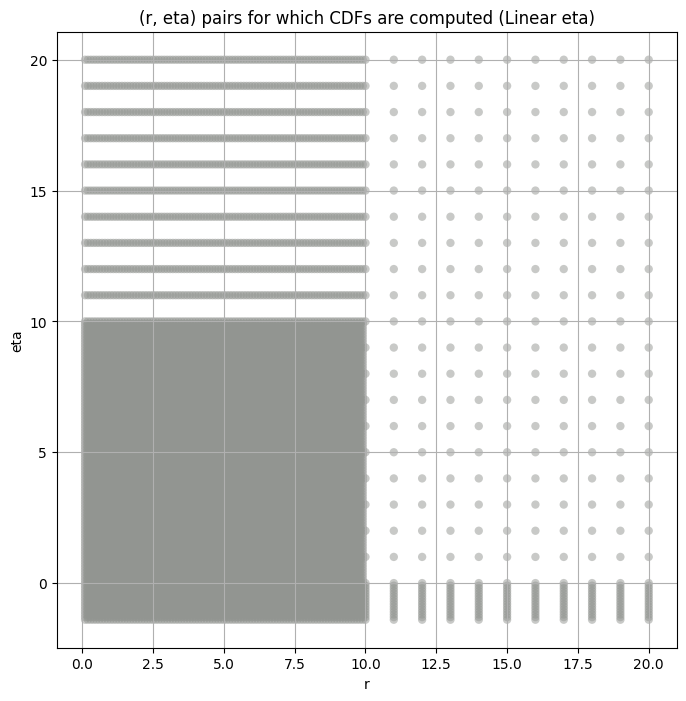

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,1.780652e+14,1.566946e+14,2.012036e+14,1.385106,0.440610,2.452241,720.0
5,3.248256e+14,2.793989e+14,3.749020e+14,30.696776,22.475871,38.184085,7200.0
8,5.841084e+13,4.986194e+13,6.893457e+13,38.618811,16.443359,62.146887,13680.0
11,7.163443e+12,6.796063e+12,7.560022e+12,2.201127,1.144515,3.771432,28080.0
14,8.842492e+13,7.518536e+13,1.036462e+14,37.136614,26.742732,55.959008,56160.0
17,4.552992e+14,4.295654e+14,4.832774e+14,3.260257,2.260875,6.270571,450720.0
20,3.092927e+13,2.903165e+13,3.301717e+13,4.174451,2.502771,8.405625,901440.0
23,5.115722e+12,4.809646e+12,5.481501e+12,4.293492,2.139704,14.028609,7211520.0
26,6.767911e+11,6.216029e+11,7.682348e+11,14.193115,3.902409,66.812514,3605760.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,1.780652e+14,1.780652e+14,1.333407e+14,1.100354e+14,9.450653e+13,8.163619e+13,6.126889e+13,4.668943e+13,3.647958e+13,2.816613e+13,2.096760e+13,6.115801e+12
5,3.248256e+14,3.248256e+14,2.370779e+14,1.984142e+14,1.746783e+14,1.581653e+14,1.365144e+14,1.250920e+14,1.165263e+14,1.096751e+14,1.039230e+14,9.070856e+13
8,5.841084e+13,5.841084e+13,4.586948e+13,4.164275e+13,3.910740e+13,3.741615e+13,3.533340e+13,3.381122e+13,3.268501e+13,3.174075e+13,3.089641e+13,2.875977e+13
11,7.163443e+12,7.163443e+12,6.929540e+12,6.804531e+12,6.703276e+12,6.614736e+12,6.468046e+12,6.349908e+12,6.245344e+12,6.150118e+12,6.061287e+12,5.824945e+12
14,8.842492e+13,8.842492e+13,8.162919e+13,7.724773e+13,7.358624e+13,7.042816e+13,6.527764e+13,6.111002e+13,5.758255e+13,5.459531e+13,5.193540e+13,4.534248e+13
17,4.552992e+14,4.552992e+14,4.460767e+14,4.402141e+14,4.351772e+14,4.306767e+14,4.228327e+14,4.159337e+14,4.097143e+14,4.040233e+14,3.987205e+14,3.844647e+14
20,3.092927e+13,3.092927e+13,3.009891e+13,2.962390e+13,2.923815e+13,2.890167e+13,2.832318e+13,2.782917e+13,2.738898e+13,2.698836e+13,2.661798e+13,2.564643e+13
23,5.115722e+12,5.115722e+12,4.981120e+12,4.909231e+12,4.850137e+12,4.798350e+12,4.708592e+12,4.630778e+12,4.561190e+12,4.497741e+12,4.439075e+12,4.283758e+12
26,6.767911e+11,6.767911e+11,6.436384e+11,6.303365e+11,6.201081e+11,6.114417e+11,5.968788e+11,5.845664e+11,5.737069e+11,5.639052e+11,5.549129e+11,5.313709e+11


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.01285709086418163 178065156509299.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.030551463181827998 133340670224868.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.04827301176146903 110035434517653.02


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.06564819458282833 94506526990195.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.08237872063200213 81636192671531.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.11455438057849388 61268885913897.375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.14336568678811668 46689428111261.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.16914341060110627 36479581769996.93


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.19604871834731907 28166130832303.312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.22377599365577044 20967602757651.008


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.31924964541780887 6115800563622.027
Number of samples: 1440, Without approximation : 720.0


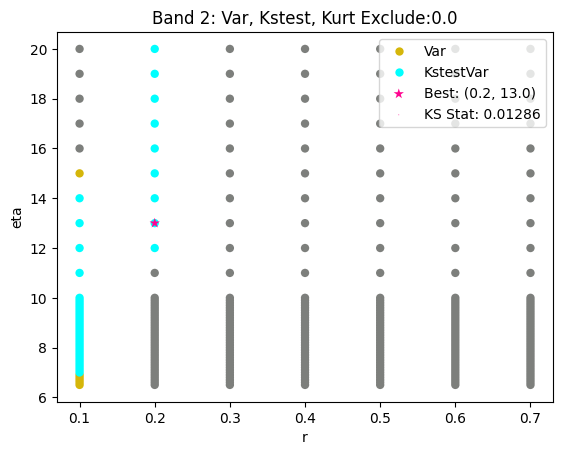

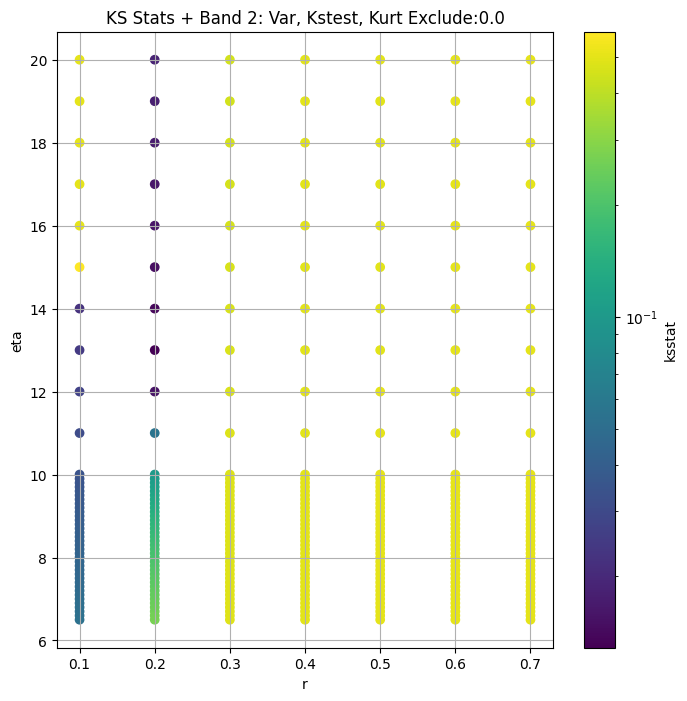

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.022730165813821812 324825565980986.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.01738770479553603 237077886183118.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.011601404994357578 198414204091362.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.00794178522626908 174678293226434.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.008598774665759756 158165338577234.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.013585078158964259 136514396125265.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.01667391834340513 125092012448140.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.019935747268311307 116526297843519.17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.023474862824069964 109675100626558.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.028839823962200528 103922980438859.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.04181785013950545 90708561409645.16
Number of samples: 14400, Without approximation : 7200.0


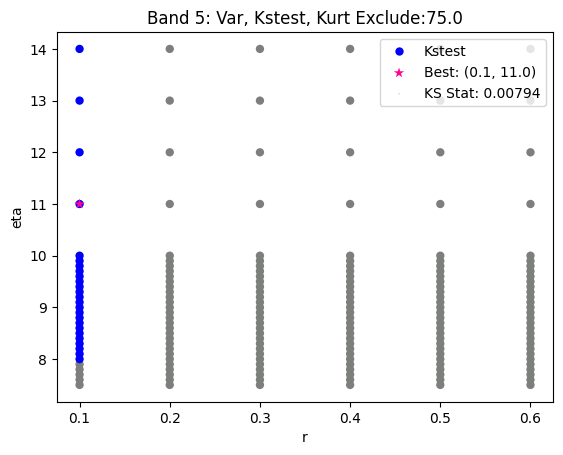

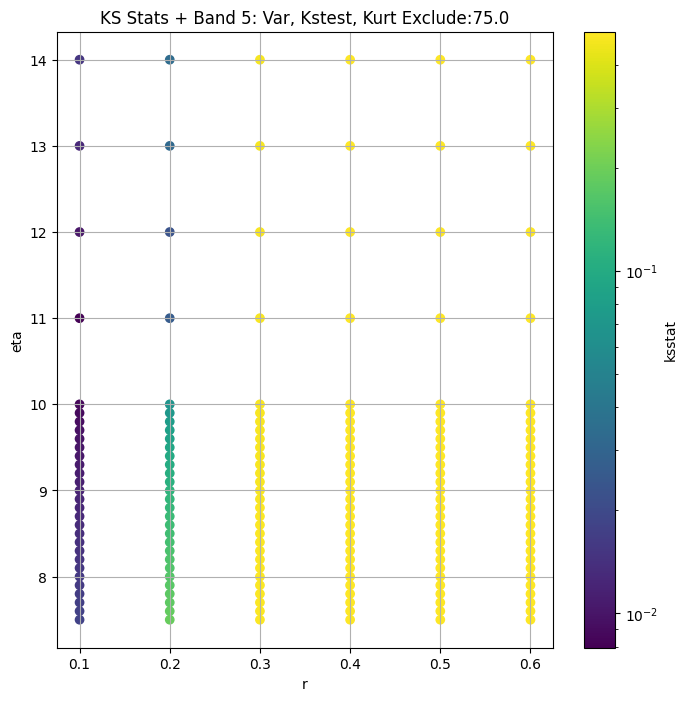

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.007621167707668519 58410843451413.41


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.007621167707668519 45869482543666.734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.00712049016602679 41642745005527.41


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.004570823446677747 39107395919029.49


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005158174541475047 37416149504276.055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.008508546390449845 35333396066105.516


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.013233784323898101 33811223485758.527


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.016963912222749927 32685011163467.617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.020208121881276964 31740752029552.875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.0232044795419456 30896407571991.746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.031222279284752102 28759774576477.62
Number of samples: 27360, Without approximation : 13680.0


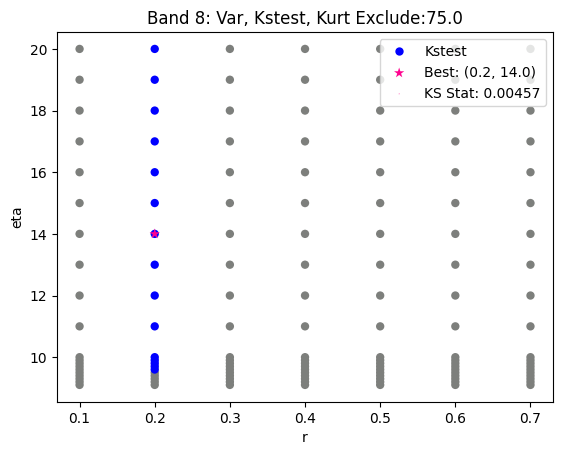

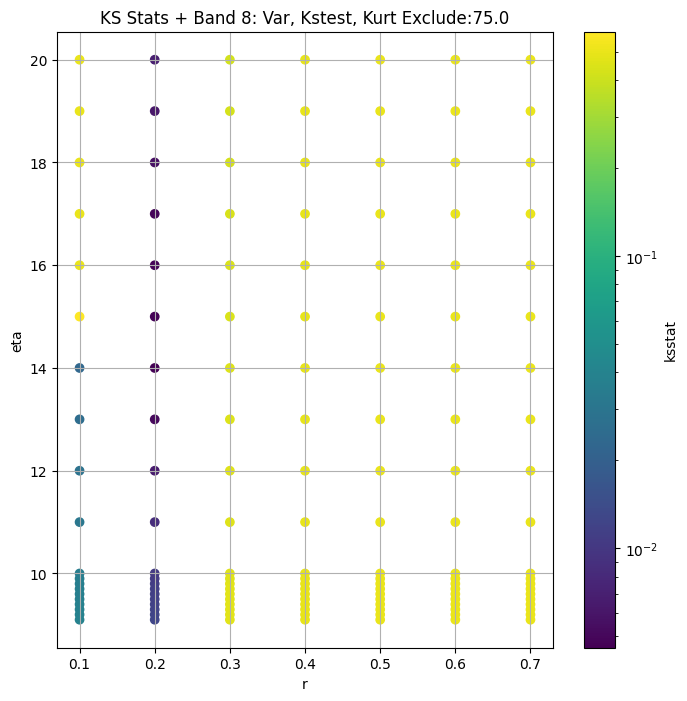

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.0035553998774977558 7163443203756.451


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.001859993351241429 6929539886577.272


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0016731938002944036 6804530650142.128


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.003239432695686162 6703275502408.127


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.004726402064230917 6614735533207.122


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0072400122834869185 6468046234240.386


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.009311288969516496 6349908009140.46


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.011180726217651343 6245343750250.988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.012913638675248834 6150118402844.005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.014557082112586883 6061287331134.416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.019061296583751997 5824944865597.052
Number of samples: 56160, Without approximation : 28080.0


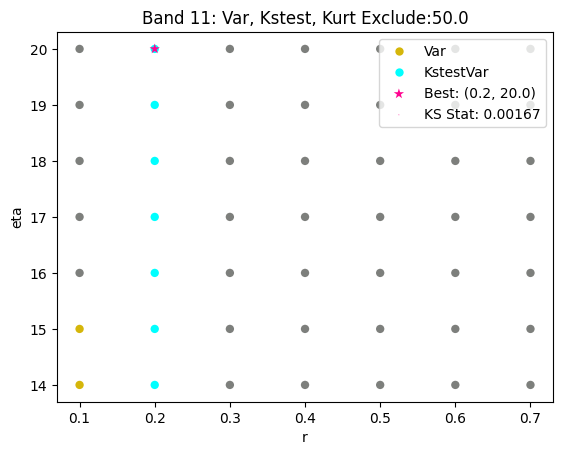

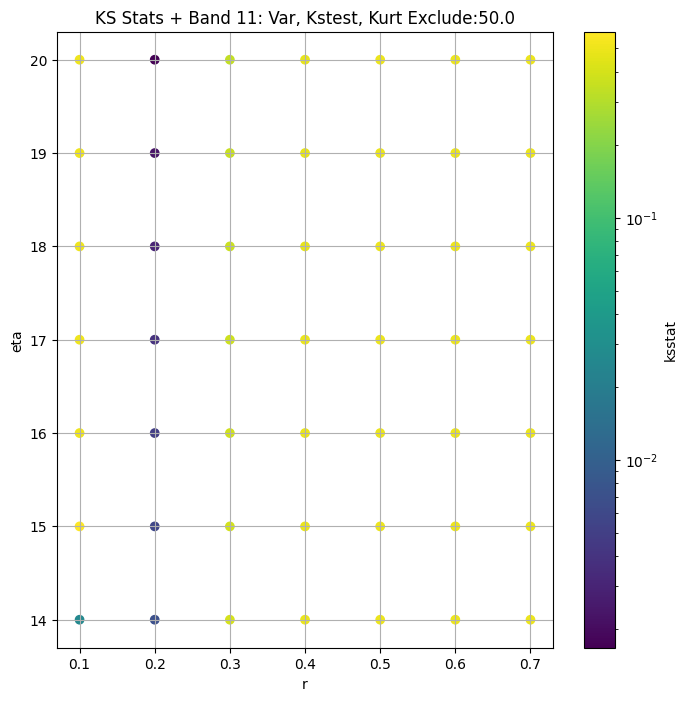

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.024473067713565833 88424916896429.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.02214134676562307 81629188127063.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.02248390301886094 77247730000645.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.019444842618470348 73586237008313.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.021154414797908416 70428163632340.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.017863135158190824 65277635212193.336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.019058897115052043 61110016749698.82


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.01712657437162085 57582549589256.695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.016952810295932763 54595313410029.15


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.015960121403334193 51935400996836.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.01426823838925706 45342478071807.945
Number of samples: 100000, Without approximation : 56160.0


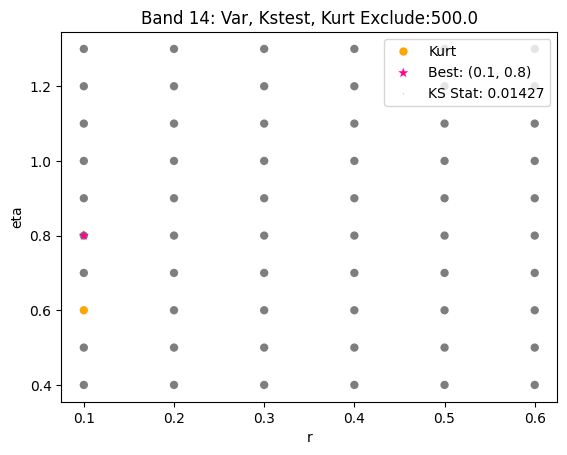

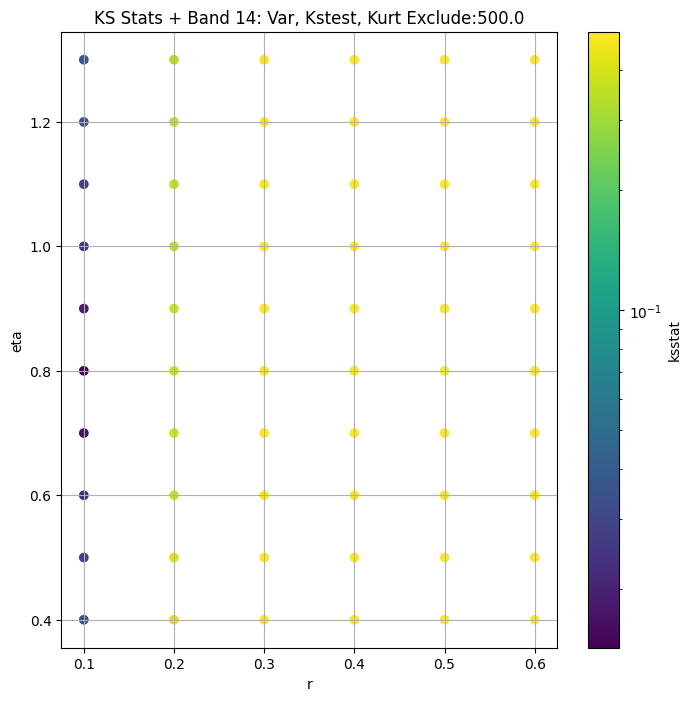

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.0075441566220219025 455299187431104.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.00810931680105531 446076697711582.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.008498597967875443 440214124237457.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.008892017877898506 435177169232116.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.009158550257812592 430676733950710.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.009765925567160758 422832730420815.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.010458416298614229 415933739116653.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.011615807774261855 409714300849182.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.011411092104361822 404023307403364.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.012395561222445117 398720526918791.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.013361275209101742 384464650042644.2
Number of samples: 100000, Without approximation : 450720.0


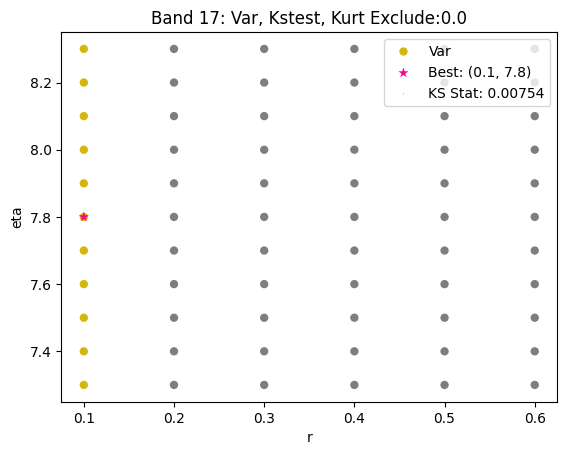

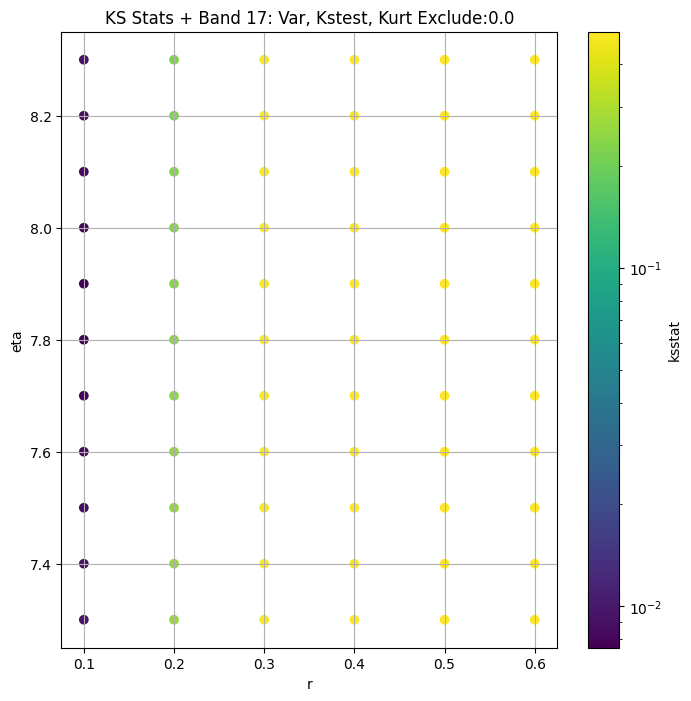

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.001468926840819229 30929274966596.152


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0007356684471658825 30098907310492.305


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0013566296683012735 29623897873488.684


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.001774438199586302 29238145616937.703


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.0022858280944276638 28901671280891.125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.0032668447914579735 28323184762251.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.004407490568362676 27829168091134.746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.004872118978843307 27388981987609.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.005572172552187799 26988363196050.812


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.006286586140979825 26617979787070.445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.008410762500762385 25646428211104.92
Number of samples: 100000, Without approximation : 901440.0


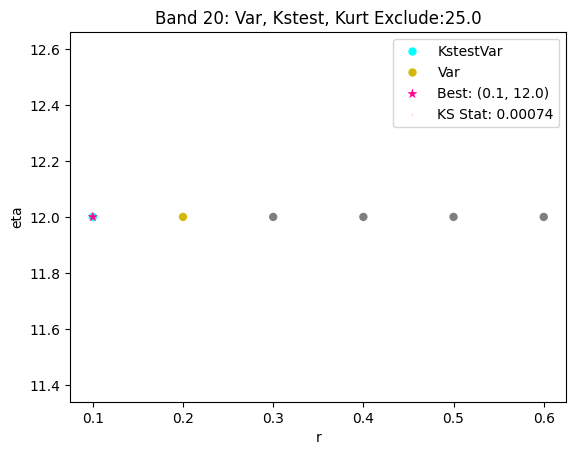

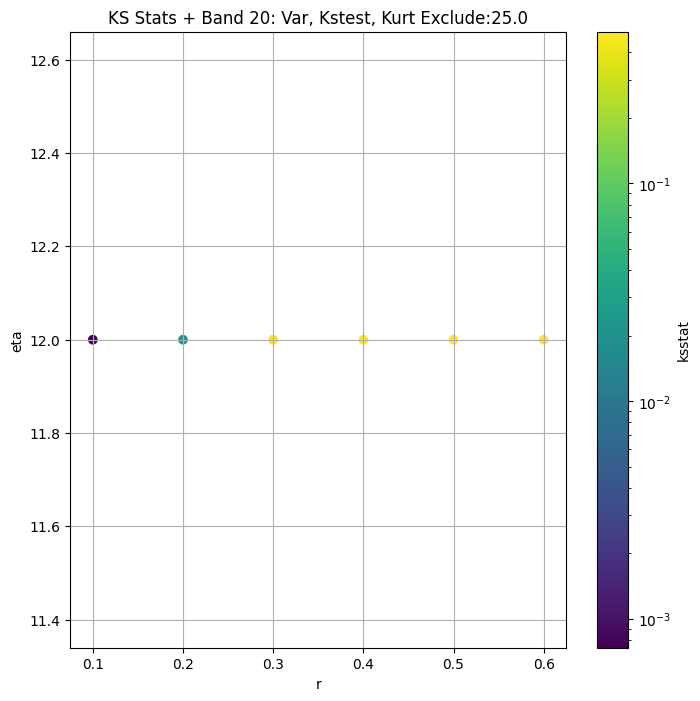

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0021118736370004942 5115721600994.127


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0009388921416284557 4981119737903.569


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0010898227501904417 4909231232574.337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0014285292481569876 4850137337676.616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0018232677348417915 4798350009628.235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0027357099946470065 4708592055890.594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0036293801025293476 4630778287857.591


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004463657552763296 4561189690928.492


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005252201098744677 4497741488714.688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.006000336254531821 4439074520879.225


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.008104697502521206 4283757735878.2666
Number of samples: 100000, Without approximation : 7211520.0


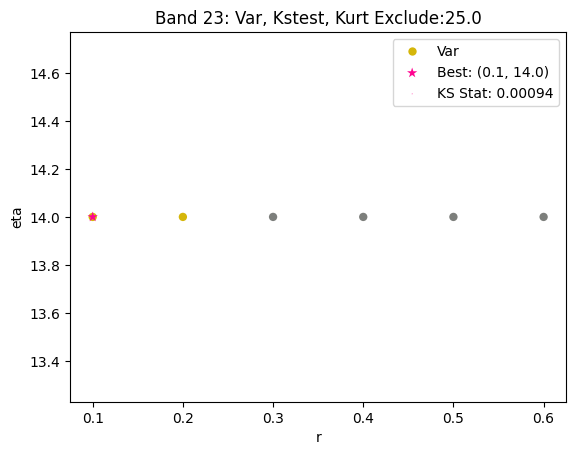

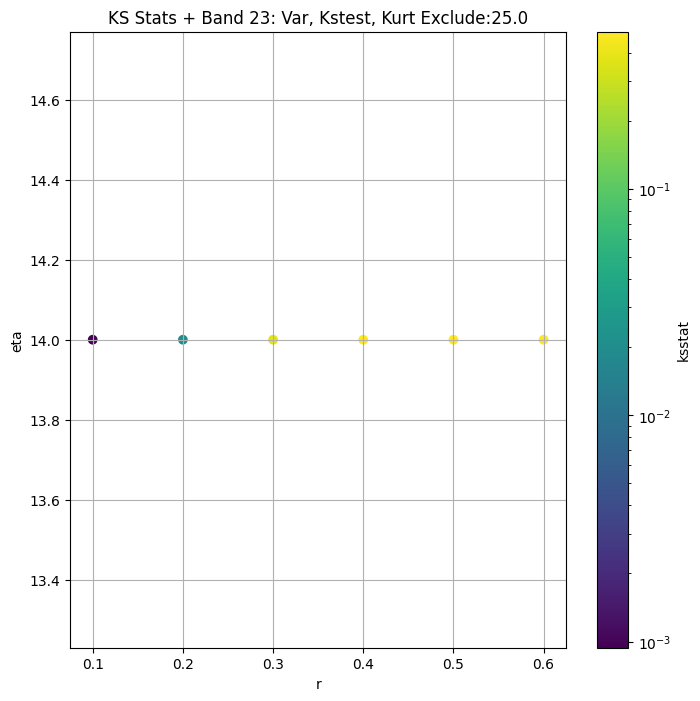

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0015109846960277284 676791070694.4324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0011843866800230543 643638378649.0183


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0015037260972454447 630336528913.4269


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.002187188859237209 620108103998.3872


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.00278395149343752 611441672974.609


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.0038457279304108874 596878835078.112


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.004769867898172936 584566445034.7678


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005630641066137872 573706926297.167


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.00645188047928217 563905237441.6913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.0072201531364377985 554912907008.9668


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.00938911455501907 531370867534.657
Number of samples: 100000, Without approximation : 3605760.0


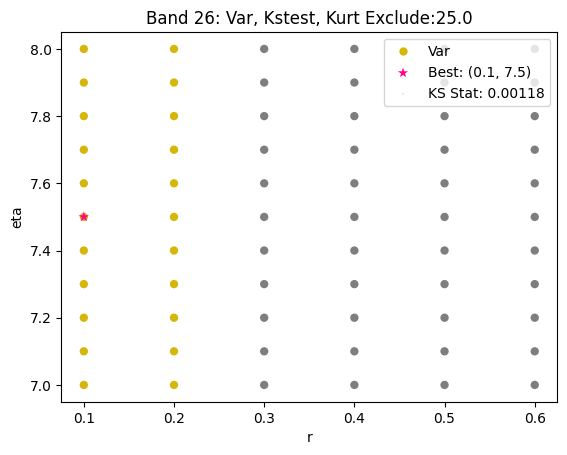

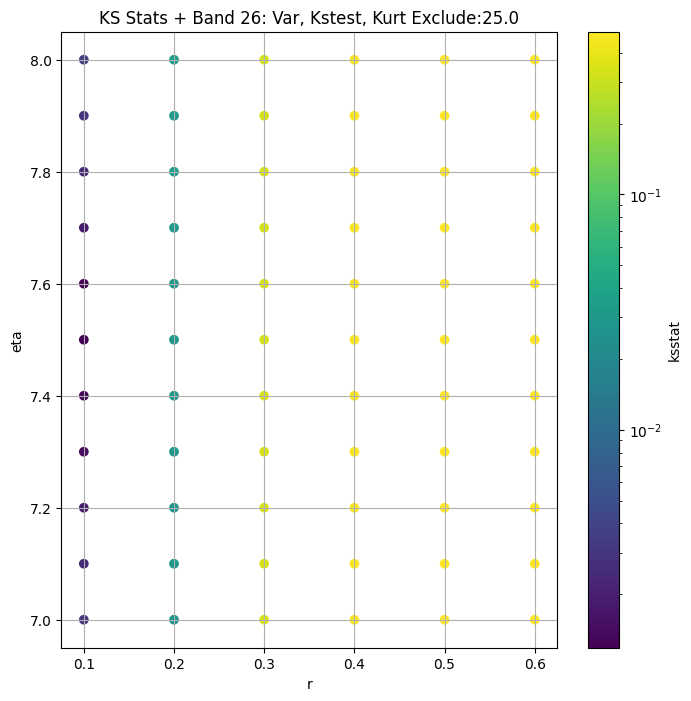

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.003520512955765942 55594045509.22258


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.0026885186068300593 53496548419.46378


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.003154018727176036 52310475799.082085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.003724911283728878 51340365374.67465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.0036697759750648033 50495412622.21946


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.004619192918954483 49041455407.80954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.005487458186343119 47793668645.46968


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.006326017065767804 46687652256.724144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.007088938783700056 45686653734.02526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.007822901199742476 44769470950.42854


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.009914799728895828 42382395886.20745
Number of samples: 100000, Without approximation : 7211520.0


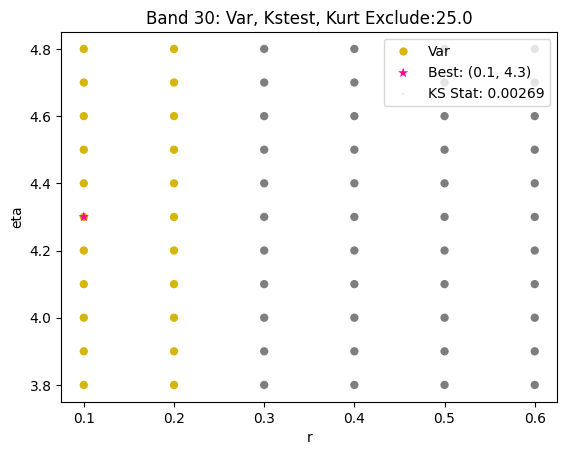

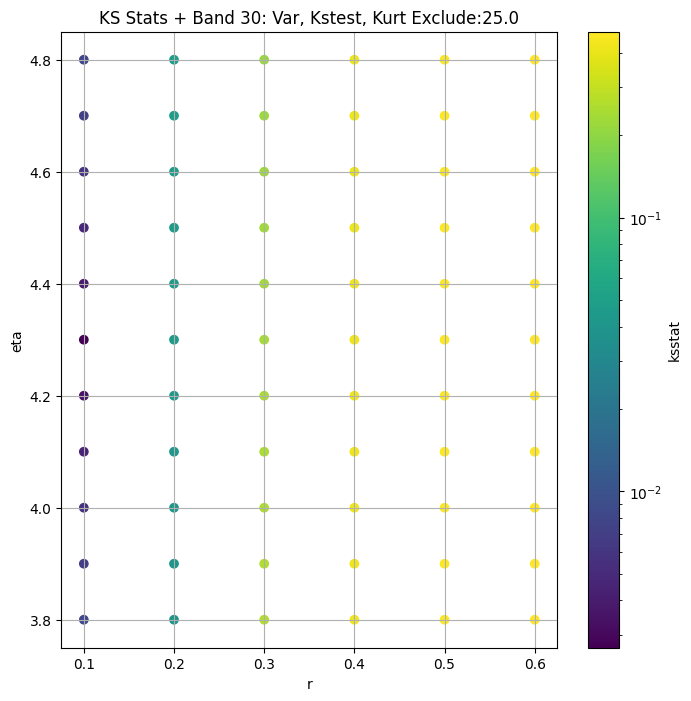

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,1.780652e+14,1.566946e+14,2.012036e+14,1.385106,0.440610,2.452241,720.0,0.012857,0.2,13.0,7.765849e+04,0.0,1.780652e+14,0.050376
5,3.248256e+14,2.793989e+14,3.749020e+14,30.696776,22.475871,38.184085,7200.0,0.007942,0.1,11.0,1.320110e-07,75.0,1.746783e+14,0.015982
8,5.841084e+13,4.986194e+13,6.893457e+13,38.618811,16.443359,62.146887,13680.0,0.004571,0.2,14.0,1.232443e+04,75.0,3.910740e+13,0.011599
11,7.163443e+12,6.796063e+12,7.560022e+12,2.201127,1.144515,3.771432,28080.0,0.001673,0.2,20.0,4.324229e+02,50.0,6.804531e+12,0.008099
14,8.842492e+13,7.518536e+13,1.036462e+14,37.136614,26.742732,55.959008,56160.0,0.014268,0.1,0.8,1.936868e-01,500.0,4.534248e+13,0.005728
17,4.552992e+14,4.295654e+14,4.832774e+14,3.260257,2.260875,6.270571,450720.0,0.007544,0.1,7.8,5.890290e-06,0.0,4.552992e+14,0.002023
20,3.092927e+13,2.903165e+13,3.301717e+13,4.174451,2.502771,8.405625,901440.0,0.000736,0.1,12.0,1.080761e-08,25.0,3.009891e+13,0.001430
23,5.115722e+12,4.809646e+12,5.481501e+12,4.293492,2.139704,14.028609,7211520.0,0.000939,0.1,14.0,4.681925e-10,25.0,4.981120e+12,0.000506
26,6.767911e+11,6.216029e+11,7.682348e+11,14.193115,3.902409,66.812514,3605760.0,0.001184,0.1,7.5,1.138496e-08,25.0,6.436384e+11,0.000715


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.08785169559230288, var: 81636192671531.14


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.07160642342773371, var: 94506526990195.44


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.05463310881475536, var: 110035434517653.02


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.03331640336168806, var: 133340670224868.56


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.00998604427287686, var: 178065156509299.75
Number of samples: 1440, Without approximation : 720.0


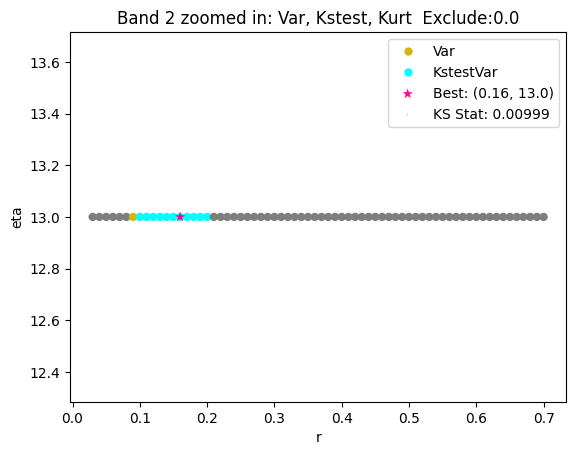

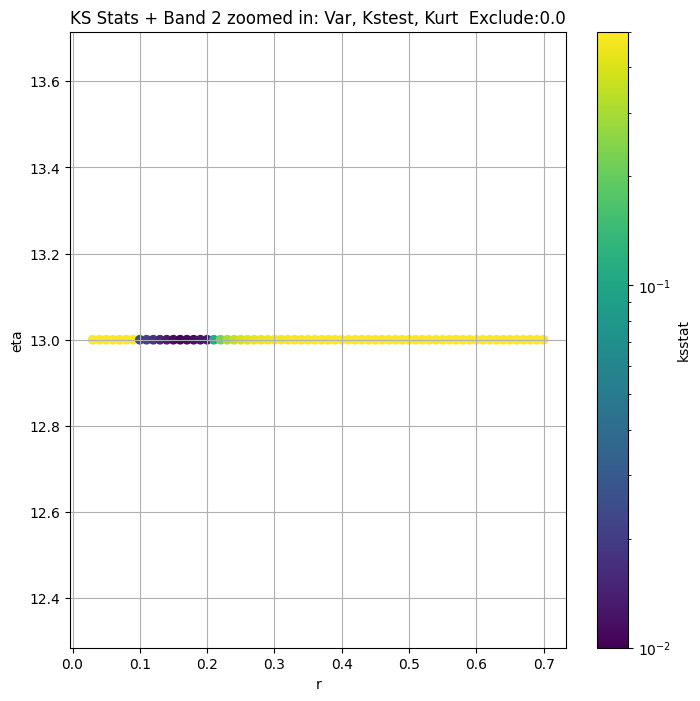

Band 5


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.014347323988759153, var: 130192881028435.48


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.012202771639543865, var: 136514396125265.16


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.01067566309722376, var: 145874393447034.94


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.008527565459860876, var: 158165338577234.5


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.00794178522626908, var: 174678293226434.56


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.013927961087047747, var: 198414204091362.44


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.026176793602097848, var: 237077886183118.22


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.026176793602097848, var: 324825565980986.6
Number of samples: 14400, Without approximation : 7200.0


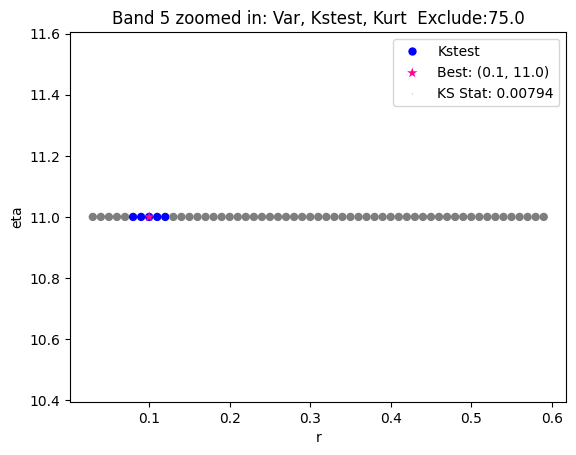

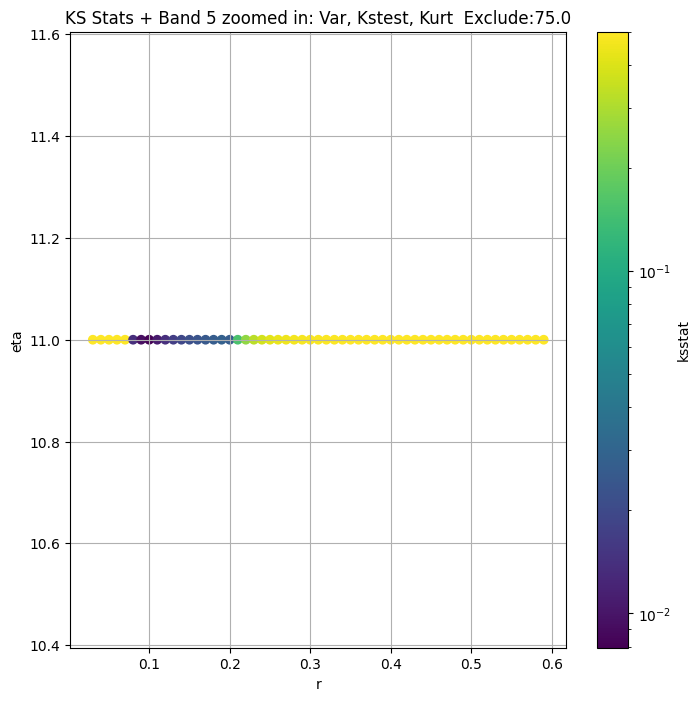

Band 8


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 75.0 + 100 = 175, ksstat: 0.015554033283219748, var: 34526538713765.93


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 75.0 + 75 = 150, ksstat: 0.013161623671551048, var: 35333396066105.516


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 75.0 + 50 = 125, ksstat: 0.010476316378223993, var: 36266794850264.805


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 75.0 + 25 = 100, ksstat: 0.007284586609196286, var: 37416149504276.055


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 75.0 + 0 = 75, ksstat: 0.004570823446677747, var: 39107395919029.49


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 75.0 + -25 = 50, ksstat: 0.0070683799564239536, var: 41642745005527.41


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 75.0 + -50 = 25, ksstat: 0.012164616807301451, var: 45869482543666.734


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 75.0 + -75 = 0, ksstat: 0.031869562486909336, var: 58410843451413.41
Number of samples: 27360, Without approximation : 13680.0


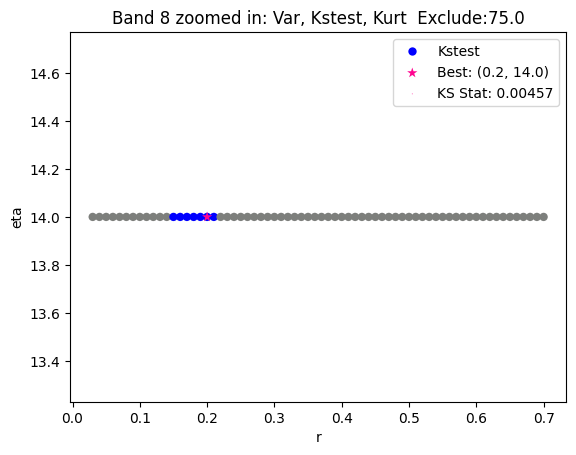

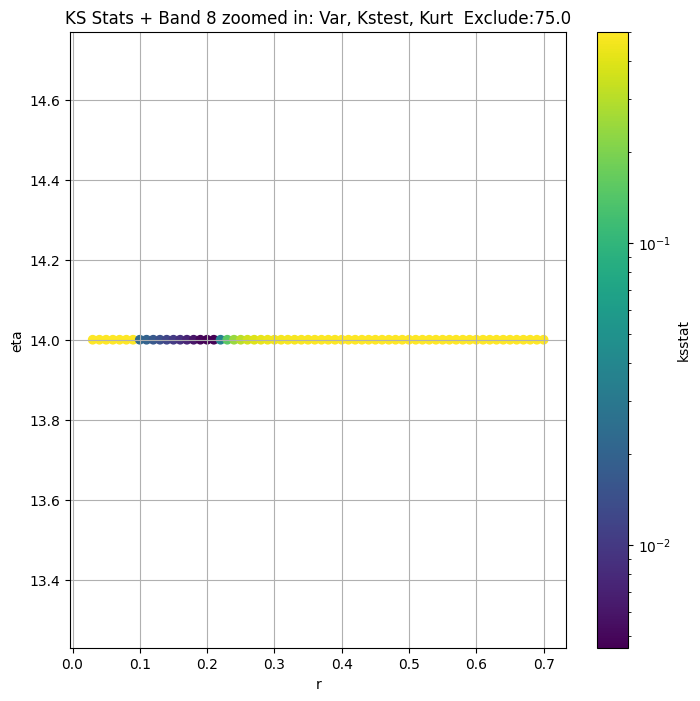

Band 11


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 50.0 + 100 = 150, ksstat: 0.0053216249876024, var: 6468046234240.386


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 50.0 + 75 = 125, ksstat: 0.004198887867192386, var: 6537108202245.895


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 50.0 + 50 = 100, ksstat: 0.002946412923228503, var: 6614735533207.122


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 50.0 + 25 = 75, ksstat: 0.001920975917940531, var: 6703275502408.127


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 50.0 + 0 = 50, ksstat: 0.0014633160787582145, var: 6804530650142.128


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 50.0 + -25 = 25, ksstat: 0.0018093070416202867, var: 6929539886577.272


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 50.0 + -50 = 0, ksstat: 0.0035319799700891386, var: 7163443203756.451
Number of samples: 56160, Without approximation : 28080.0


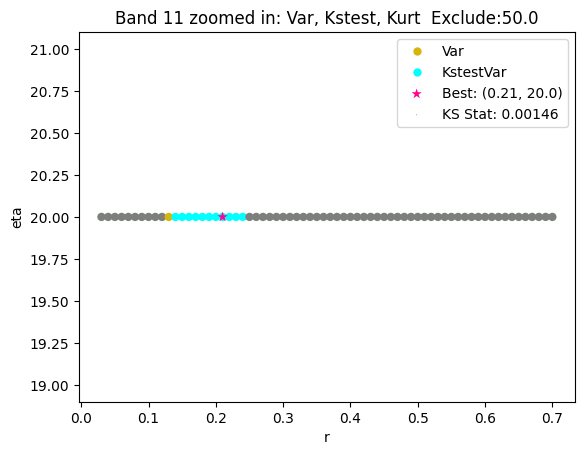

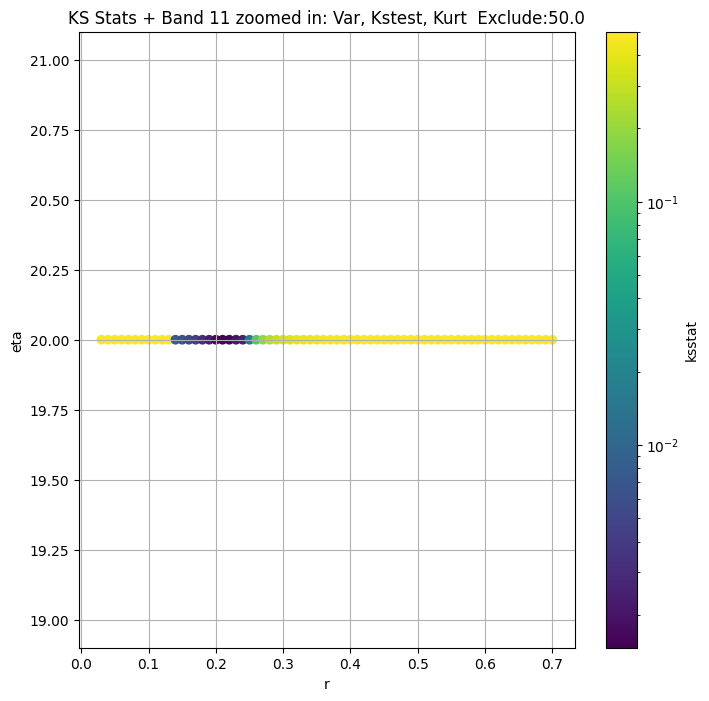

Band 14


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 500.0 + 100 = 600, ksstat: 0.013136519195151464, var: 41810142195985.76


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 500.0 + 75 = 575, ksstat: 0.013215943092675153, var: 42638295760086.414


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 500.0 + 50 = 550, ksstat: 0.012394400258168292, var: 43499140385192.24


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 500.0 + 25 = 525, ksstat: 0.012805642048633104, var: 44400366044567.59


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 500.0 + 0 = 500, ksstat: 0.01426823838925706, var: 45342478071807.945


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 500.0 + -25 = 475, ksstat: 0.013857776627798468, var: 46329588124734.22


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 500.0 + -50 = 450, ksstat: 0.013395762911147746, var: 47351693287354.51


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 500.0 + -75 = 425, ksstat: 0.013928179754796322, var: 48419328238360.305


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 500.0 + -100 = 400, ksstat: 0.015446397235106324, var: 49543706611106.74
Number of samples: 100000, Without approximation : 56160.0


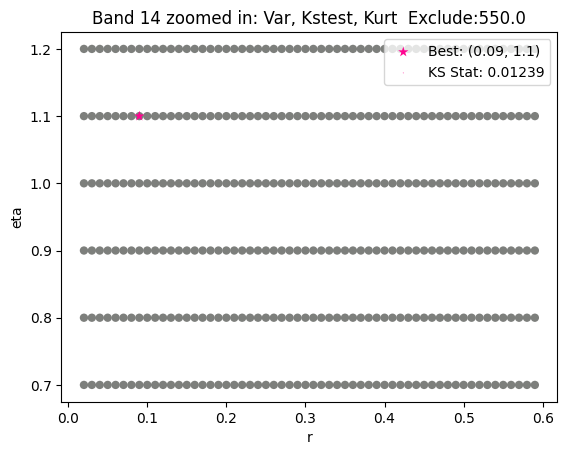

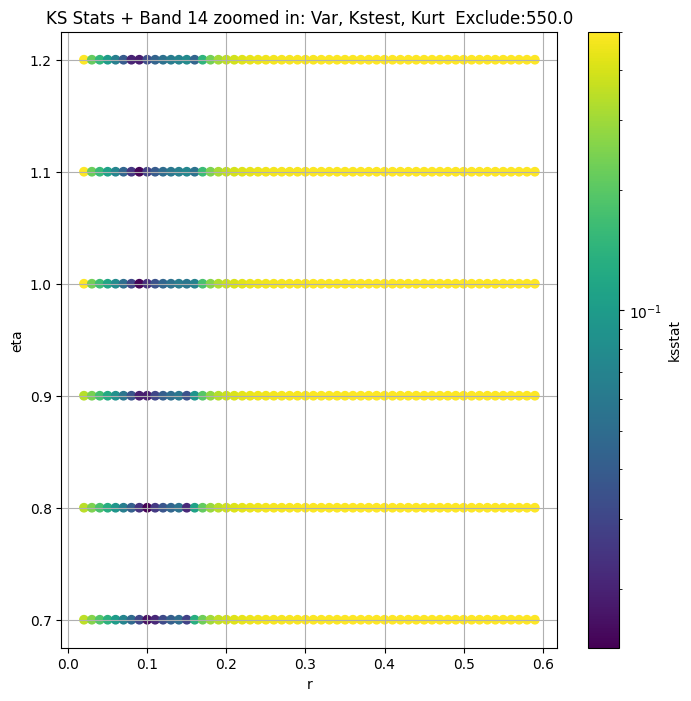

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.009110244830696265, var: 430676733950710.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.008756242505635892, var: 435177169232116.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.008415961206767741, var: 440214124237457.9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.008103324941769463, var: 446076697711582.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.0075441566220219025, var: 455299187431104.0
Number of samples: 100000, Without approximation : 450720.0


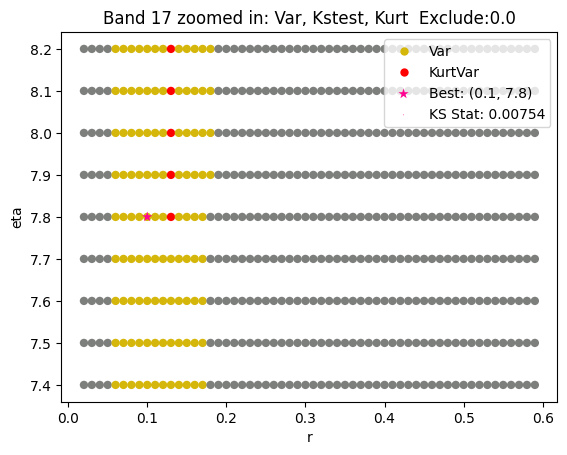

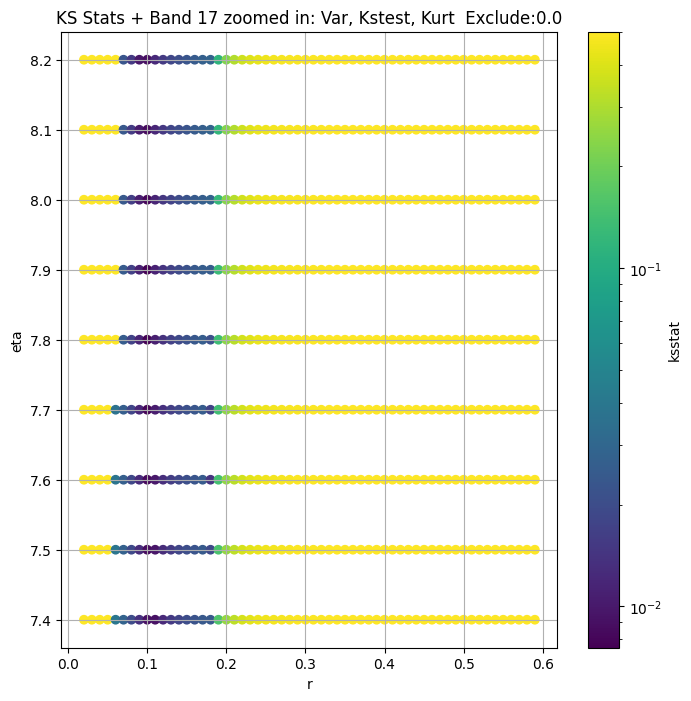

Band 20


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.002766777854919973, var: 28599714259149.766


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.0022771886217565346, var: 28901671280891.125


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.001820202079273709, var: 29238145616937.703


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.0013566296683012735, var: 29623897873488.684


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0007356684471658825, var: 30098907310492.305


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.001919362014615067, var: 30929274966596.152
Number of samples: 100000, Without approximation : 901440.0


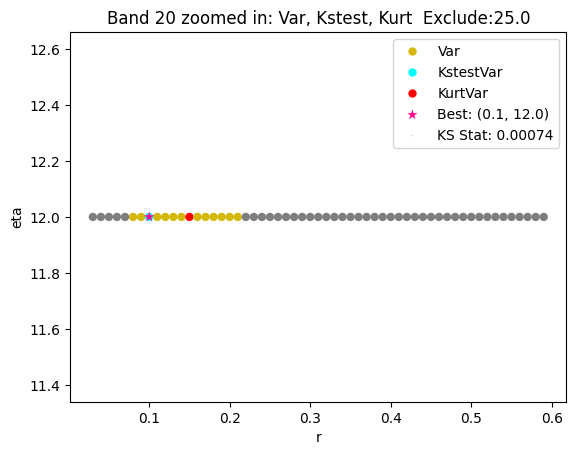

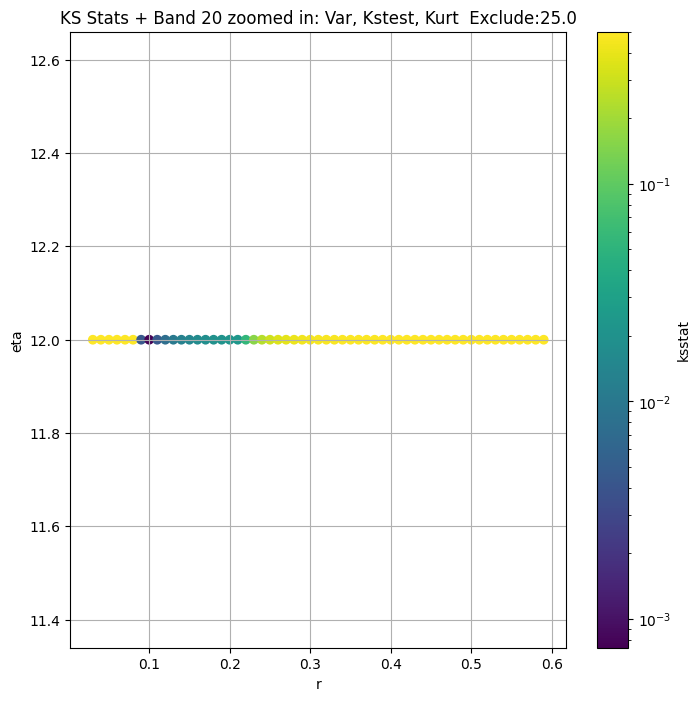

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.002457273350965447, var: 4751636255336.494


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.002020448134519324, var: 4798350009628.235


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0016413722936313851, var: 4850137337676.616


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.0015556911309691501, var: 4909231232574.337


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0009388921416284557, var: 4981119737903.569


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.0036201069722202606, var: 5115721600994.127
Number of samples: 100000, Without approximation : 7211520.0


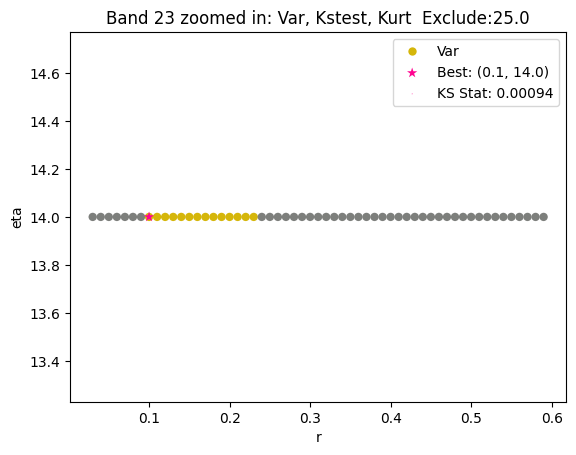

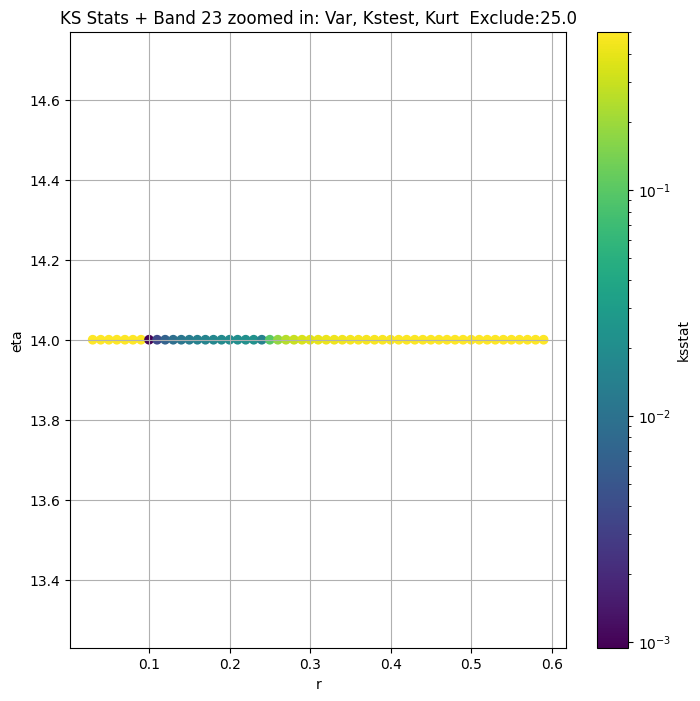

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 100 = 125, ksstat: 0.003650673084149965, var: 603799278479.407


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 75 = 100, ksstat: 0.003169195622557866, var: 611441672974.609


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 50 = 75, ksstat: 0.0025721911053759455, var: 620108103998.3872


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 25 = 50, ksstat: 0.0019240609703172068, var: 630336528913.4269


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 0 = 25, ksstat: 0.0011843866800230543, var: 643638378649.0183


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + -25 = 0, ksstat: 0.0013509059391020317, var: 676791070694.4324
Number of samples: 100000, Without approximation : 3605760.0


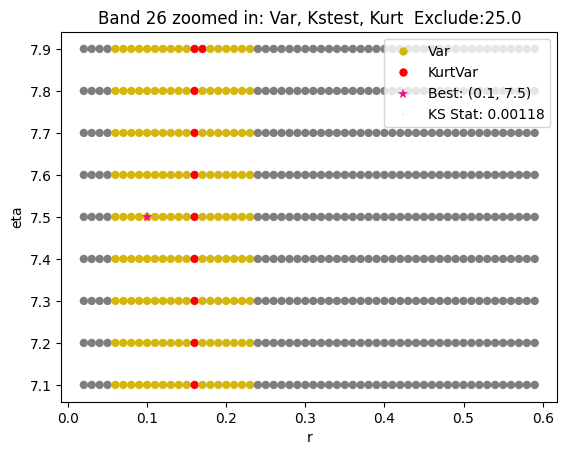

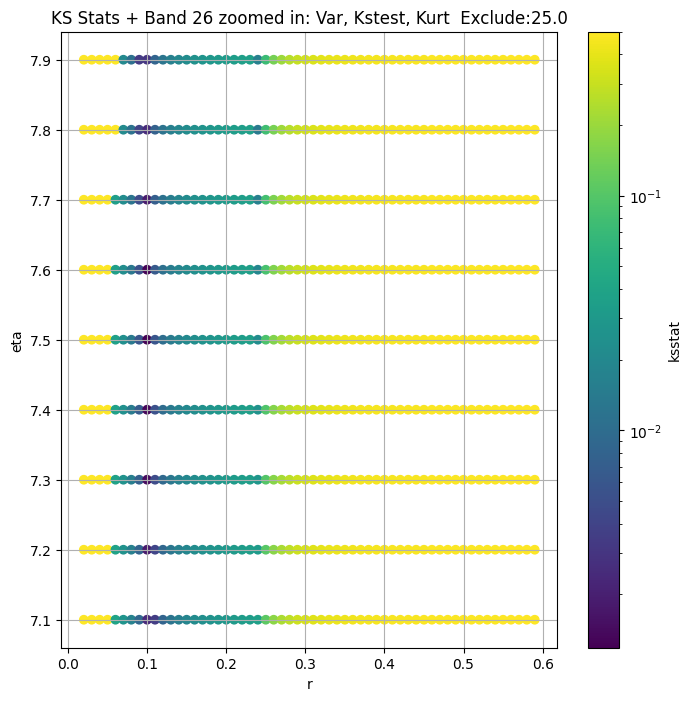

Band 30


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 100 = 125, ksstat: 0.004604690029576683, var: 49736778443.594284


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 75 = 100, ksstat: 0.004163645457099442, var: 50495412622.21946


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 50 = 75, ksstat: 0.0036615833313241586, var: 51340365374.67465


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 25 = 50, ksstat: 0.003101079489026319, var: 52310475799.082085


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 0 = 25, ksstat: 0.0026885186068300593, var: 53496548419.46378


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + -25 = 0, ksstat: 0.0032037830464205497, var: 55594045509.22258
Number of samples: 100000, Without approximation : 7211520.0


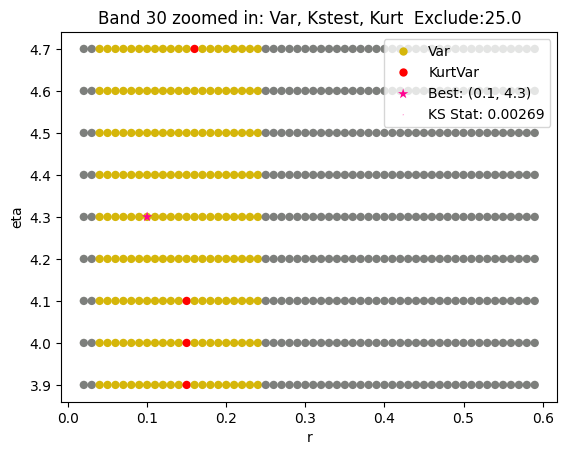

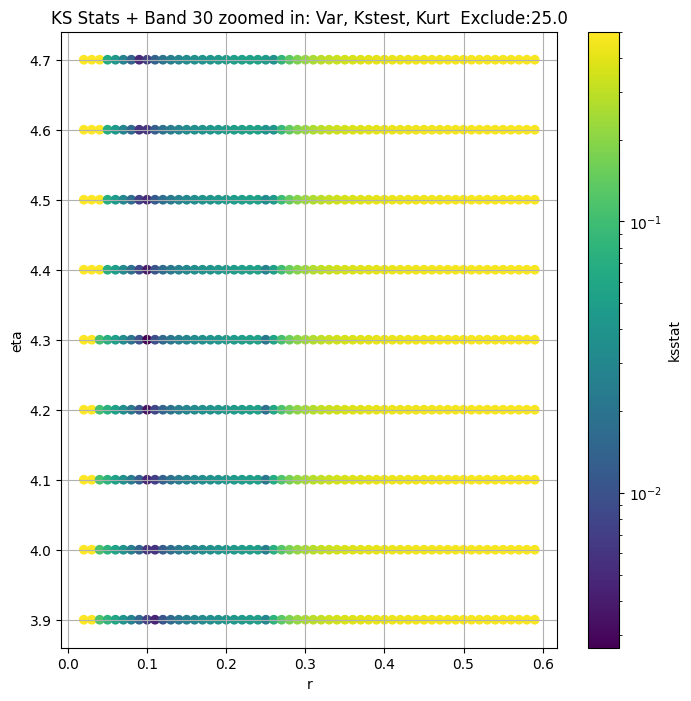

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,1.780652e+14,1.566946e+14,2.012036e+14,1.385106,0.440610,2.452241,720.0,0.012857,0.2,13.0,7.765849e+04,0.0,1.780652e+14,0.050376,0.009986,0.16,13.0,8.725070e+01,0.0,18450
5,3.248256e+14,2.793989e+14,3.749020e+14,30.696776,22.475871,38.184085,7200.0,0.007942,0.1,11.0,1.320110e-07,75.0,1.746783e+14,0.015982,0.007942,0.10,11.0,1.320110e-07,75.0,30753
8,5.841084e+13,4.986194e+13,6.893457e+13,38.618811,16.443359,62.146887,13680.0,0.004571,0.2,14.0,1.232443e+04,75.0,3.910740e+13,0.011599,0.004571,0.20,14.0,1.232443e+04,75.0,87649
11,7.163443e+12,6.796063e+12,7.560022e+12,2.201127,1.144515,3.771432,28080.0,0.001673,0.2,20.0,4.324229e+02,50.0,6.804531e+12,0.008099,0.001463,0.21,20.0,1.670505e+03,50.0,910815
14,8.842492e+13,7.518536e+13,1.036462e+14,37.136614,26.742732,55.959008,56160.0,0.014268,0.1,0.8,1.936868e-01,500.0,4.349914e+13,0.005728,0.012394,0.09,1.1,4.482071e-04,550.0,11845
17,4.552992e+14,4.295654e+14,4.832774e+14,3.260257,2.260875,6.270571,450720.0,0.007544,0.1,7.8,5.890290e-06,0.0,4.552992e+14,0.002023,0.007544,0.10,7.8,5.890290e-06,0.0,31690
20,3.092927e+13,2.903165e+13,3.301717e+13,4.174451,2.502771,8.405625,901440.0,0.000736,0.1,12.0,1.080761e-08,25.0,3.009891e+13,0.001430,0.000736,0.10,12.0,1.080761e-08,25.0,3422655
23,5.115722e+12,4.809646e+12,5.481501e+12,4.293492,2.139704,14.028609,7211520.0,0.000939,0.1,14.0,4.681925e-10,25.0,4.981120e+12,0.000506,0.000939,0.10,14.0,4.681925e-10,25.0,2028240
26,6.767911e+11,6.216029e+11,7.682348e+11,14.193115,3.902409,66.812514,3605760.0,0.001184,0.1,7.5,1.138496e-08,25.0,6.436384e+11,0.000715,0.001184,0.10,7.5,1.138496e-08,25.0,1352160


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

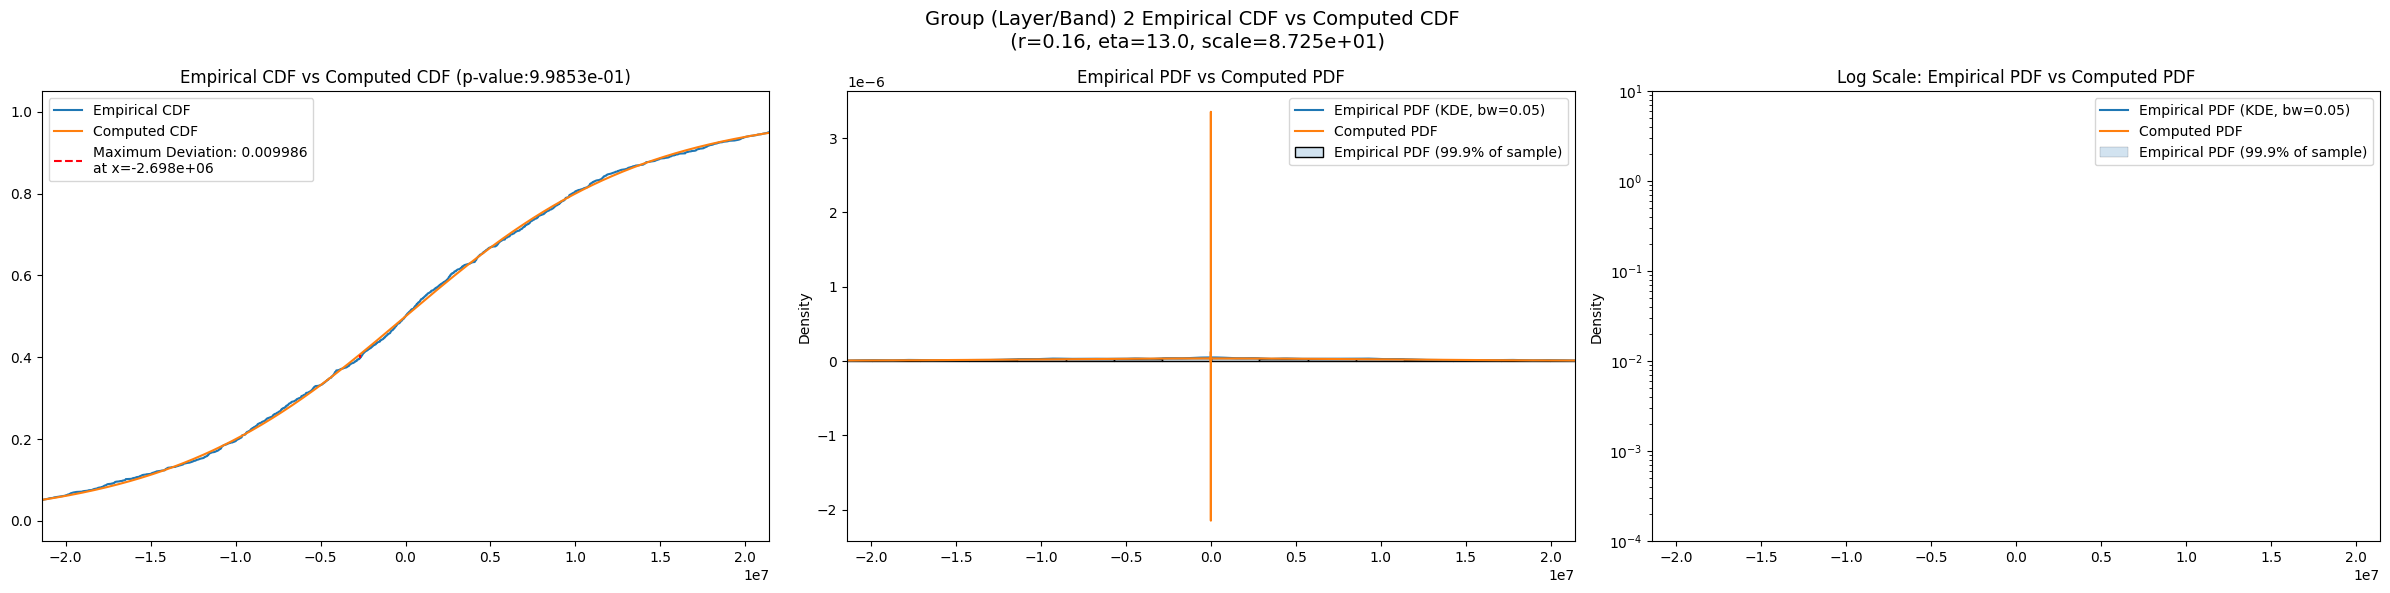

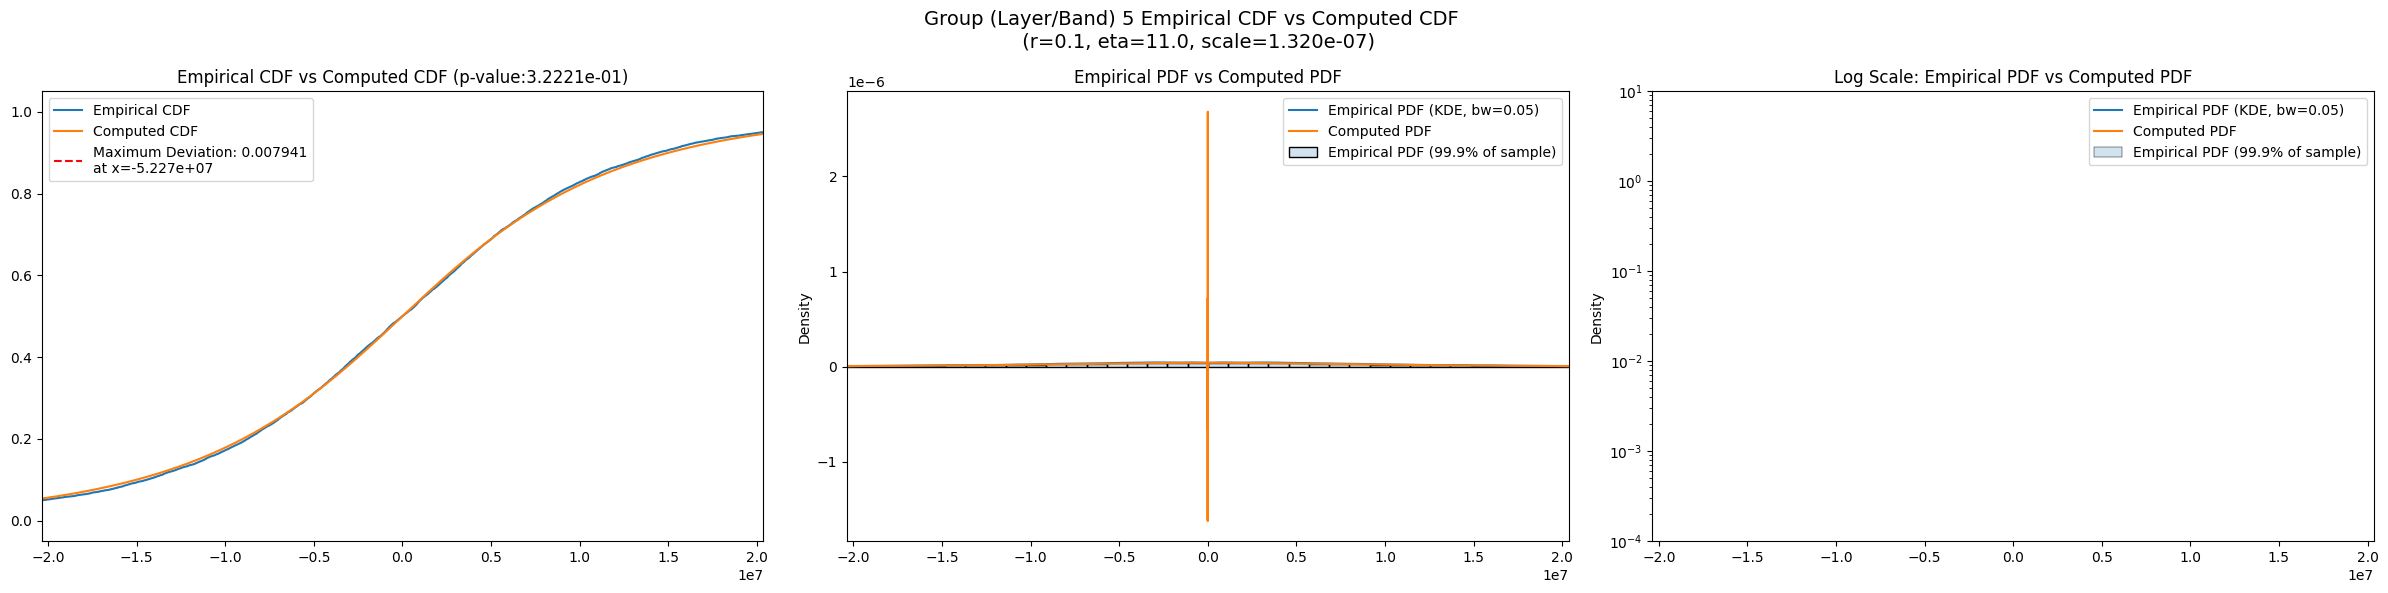

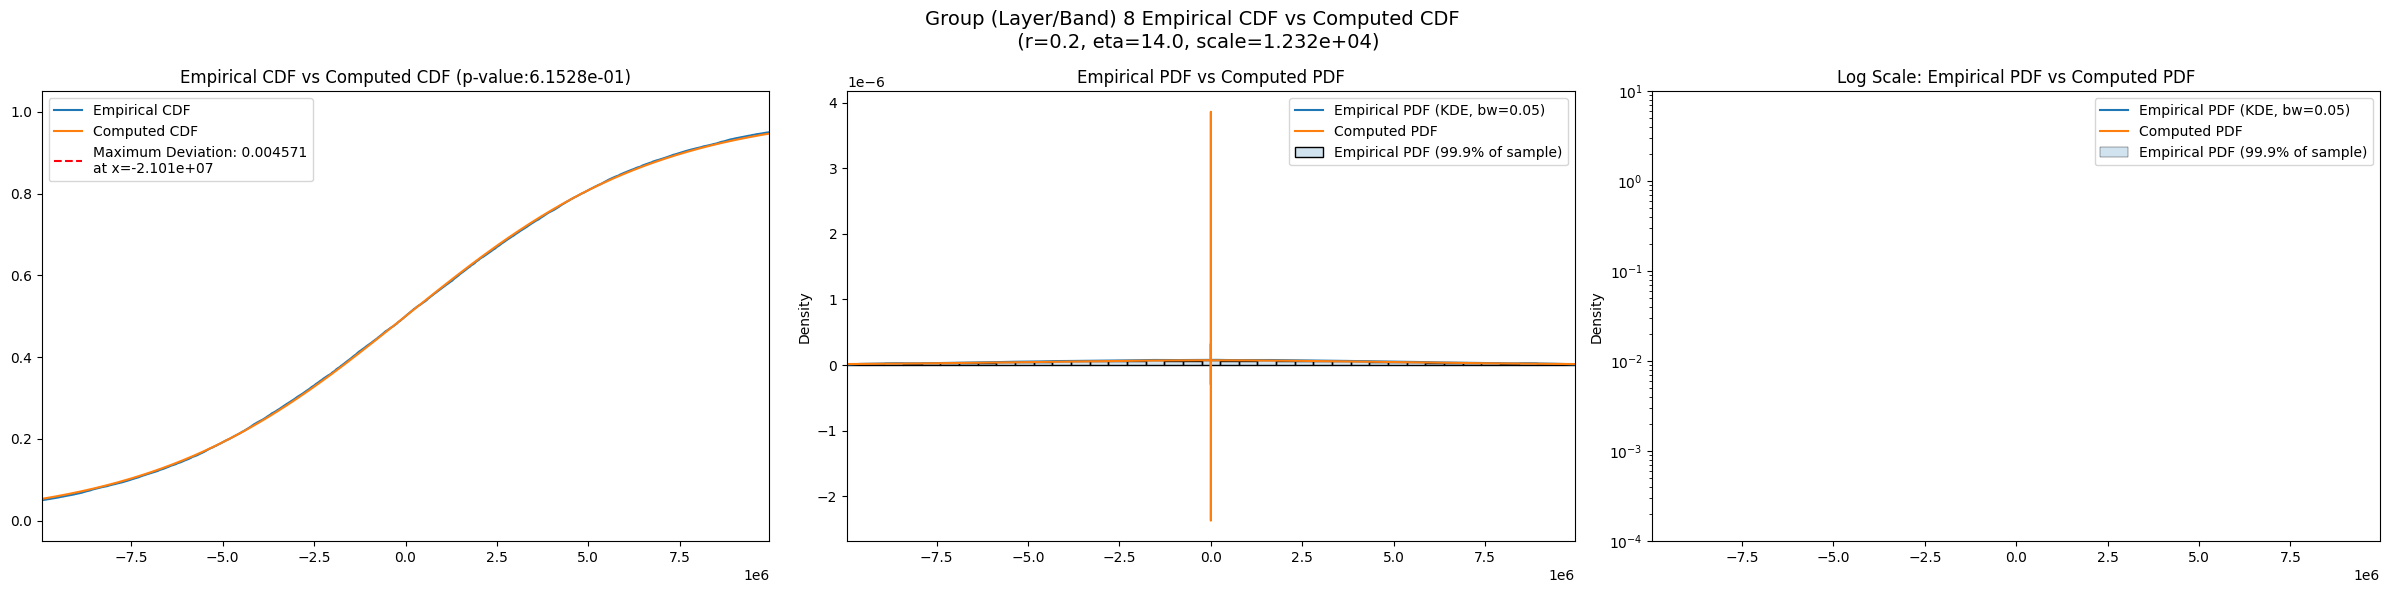

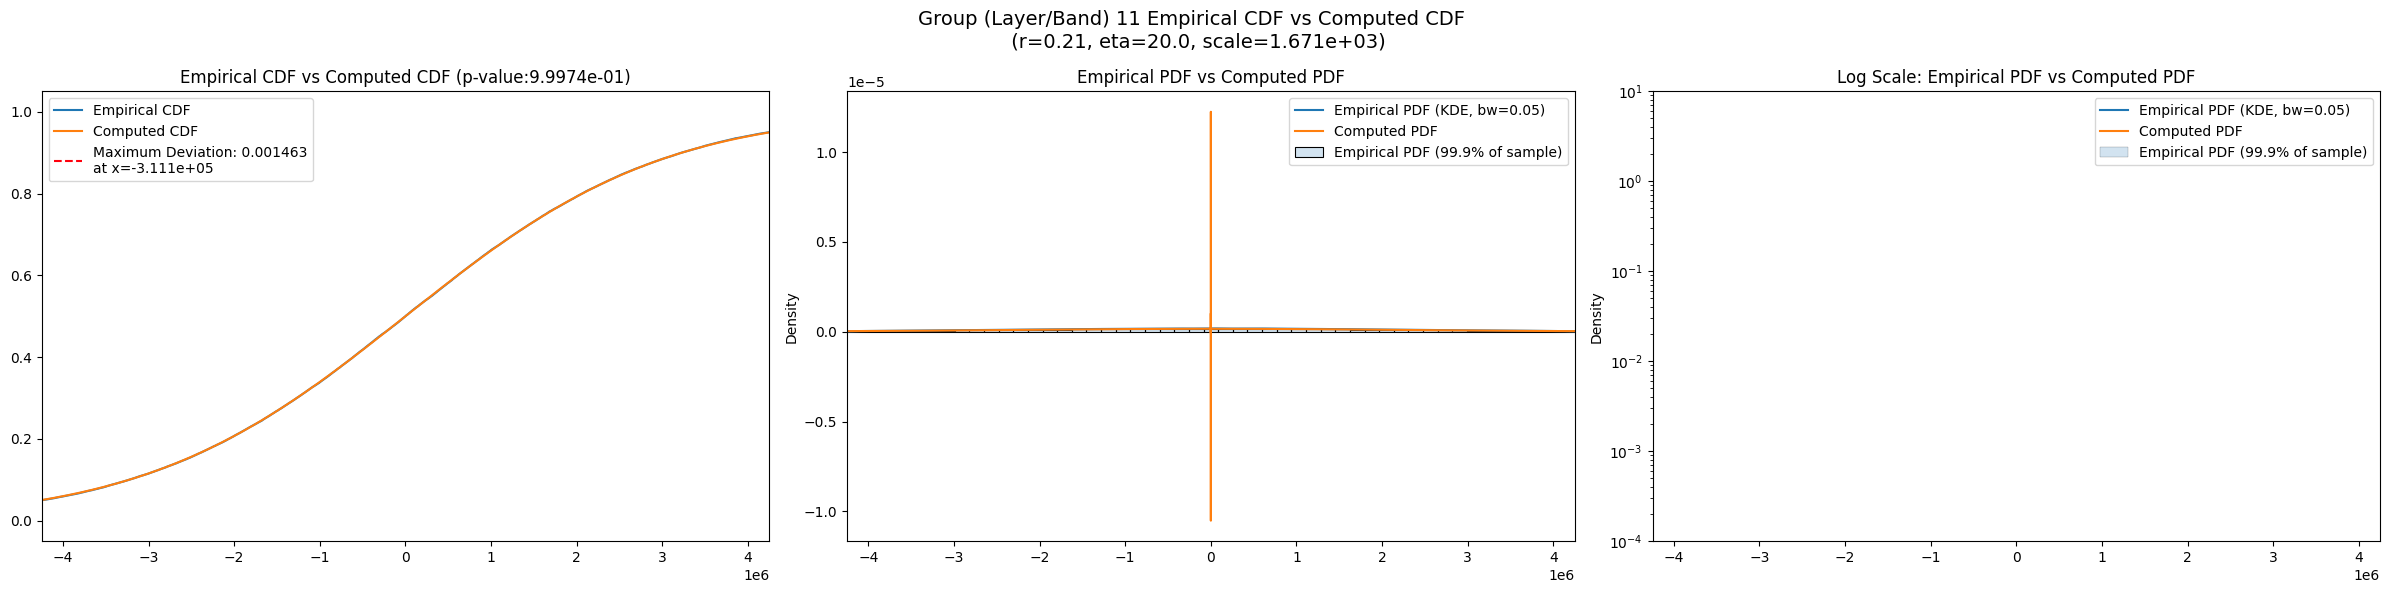

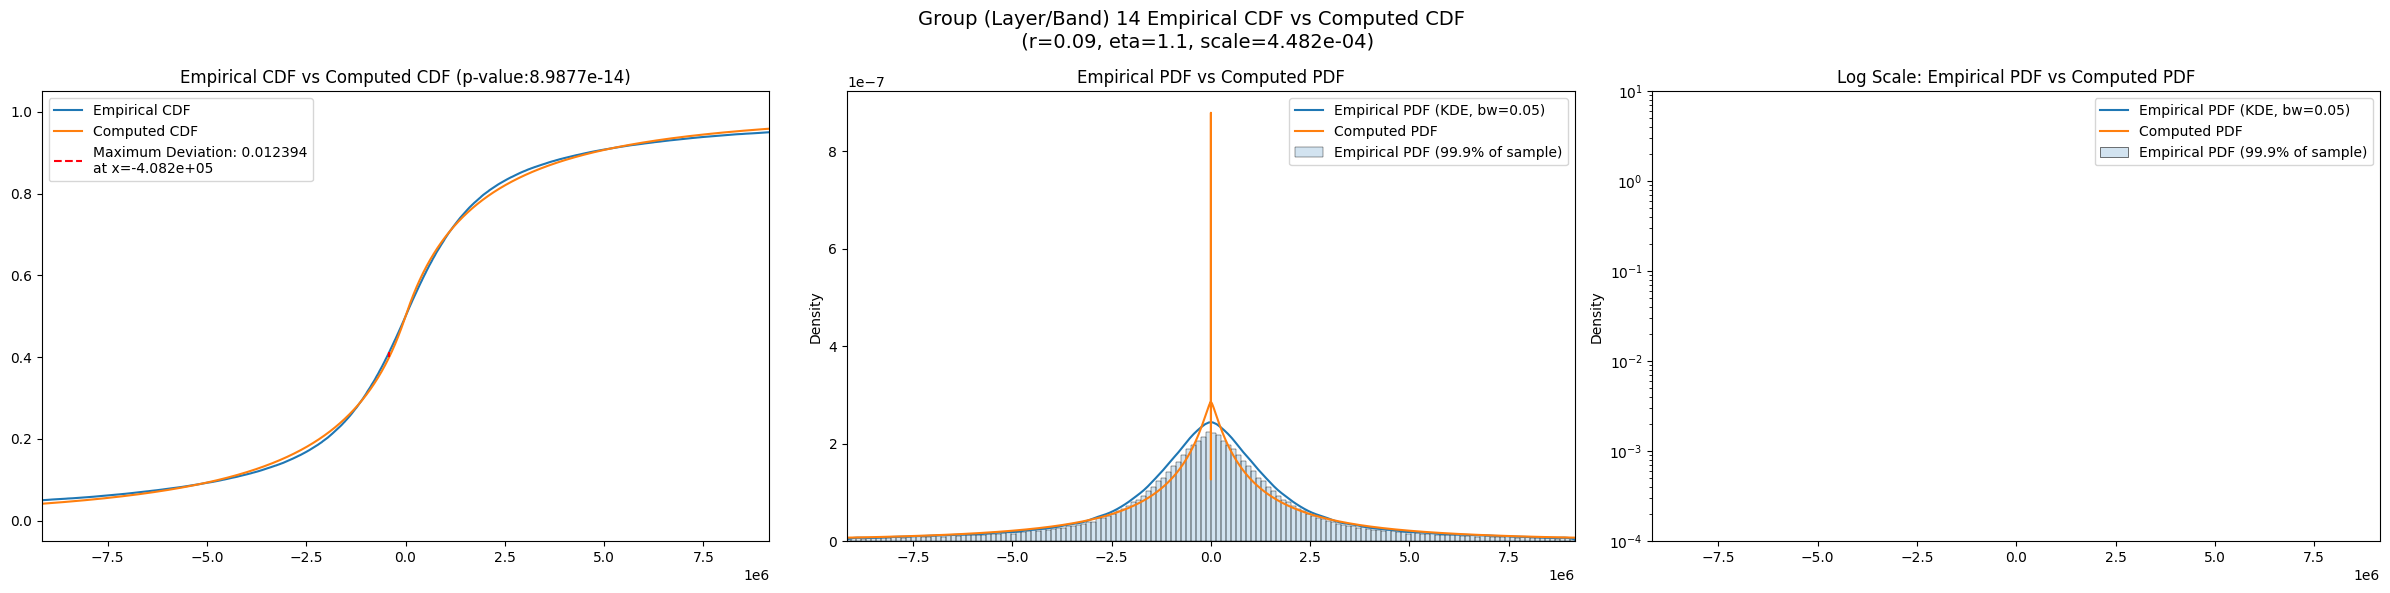

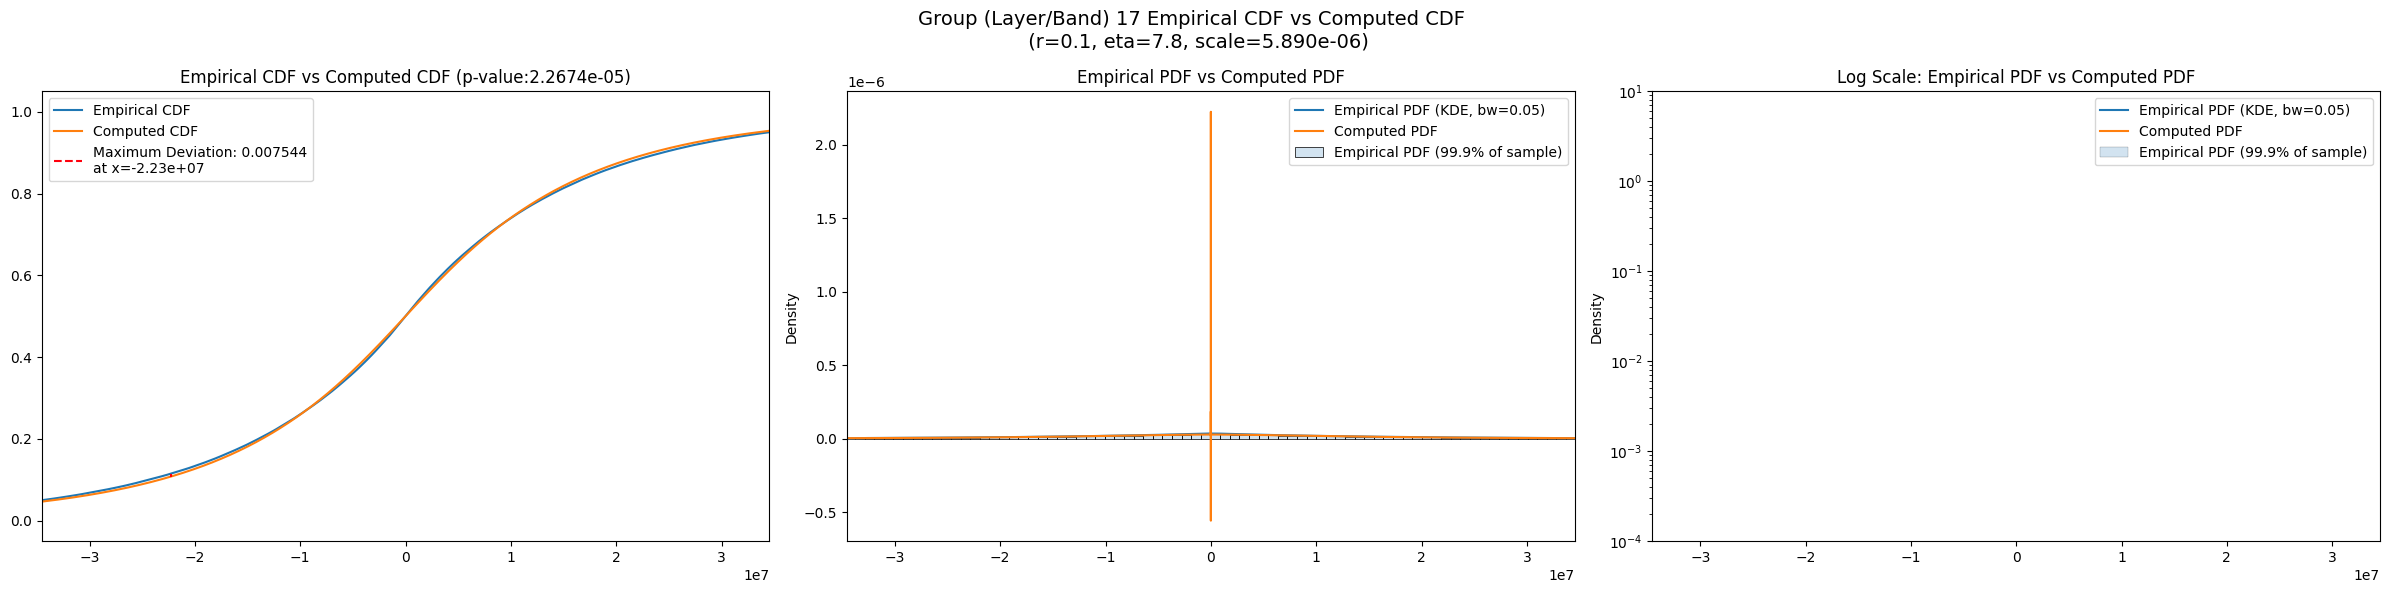

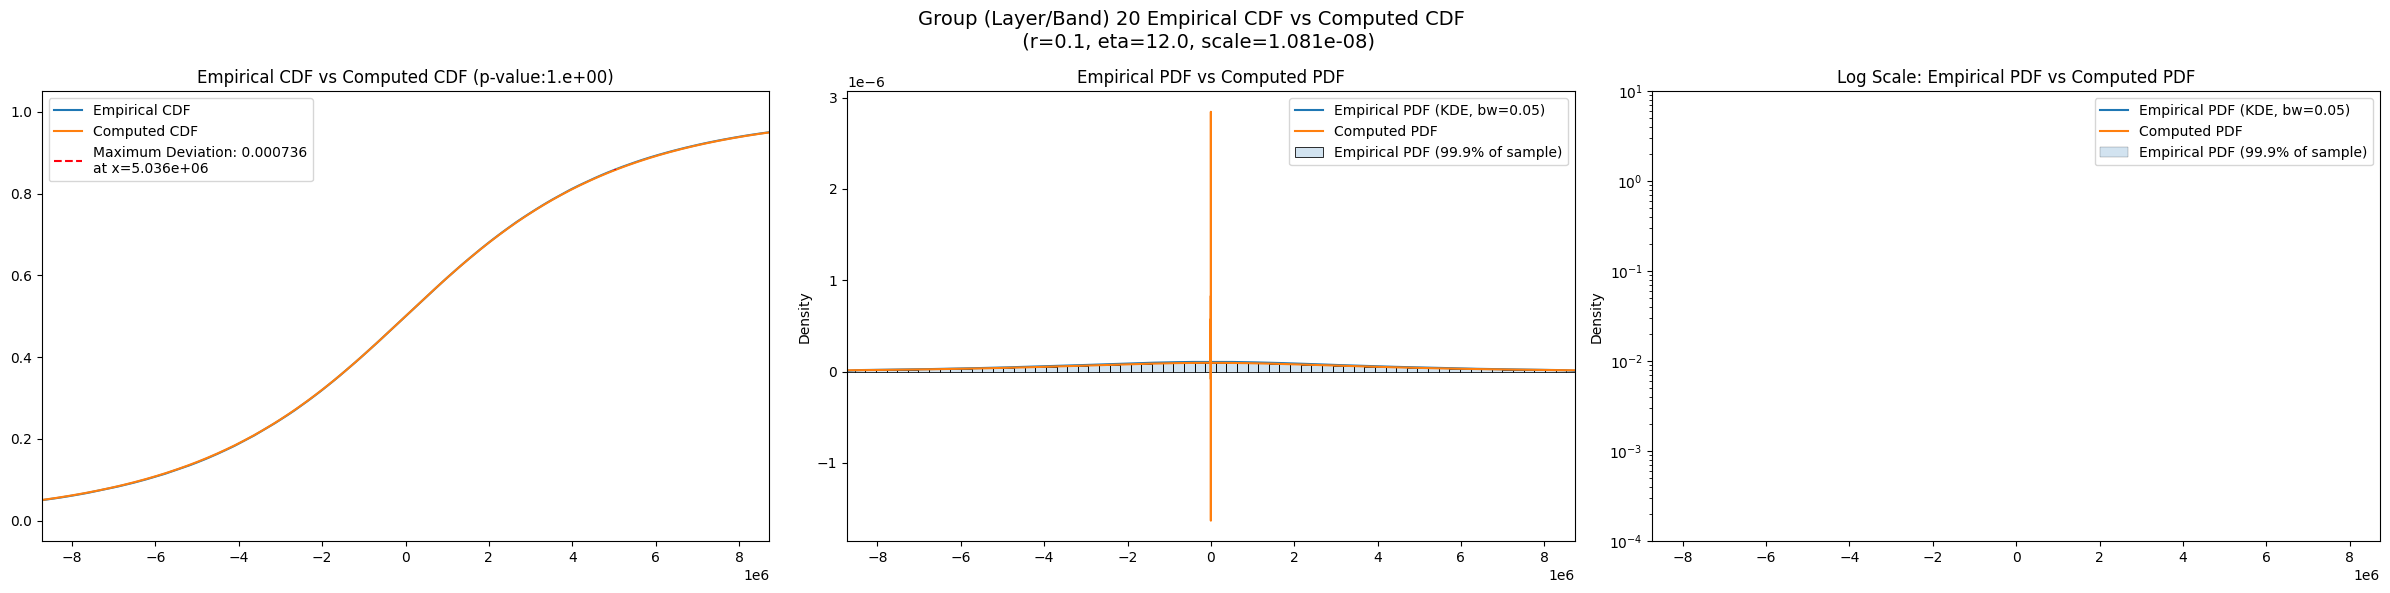

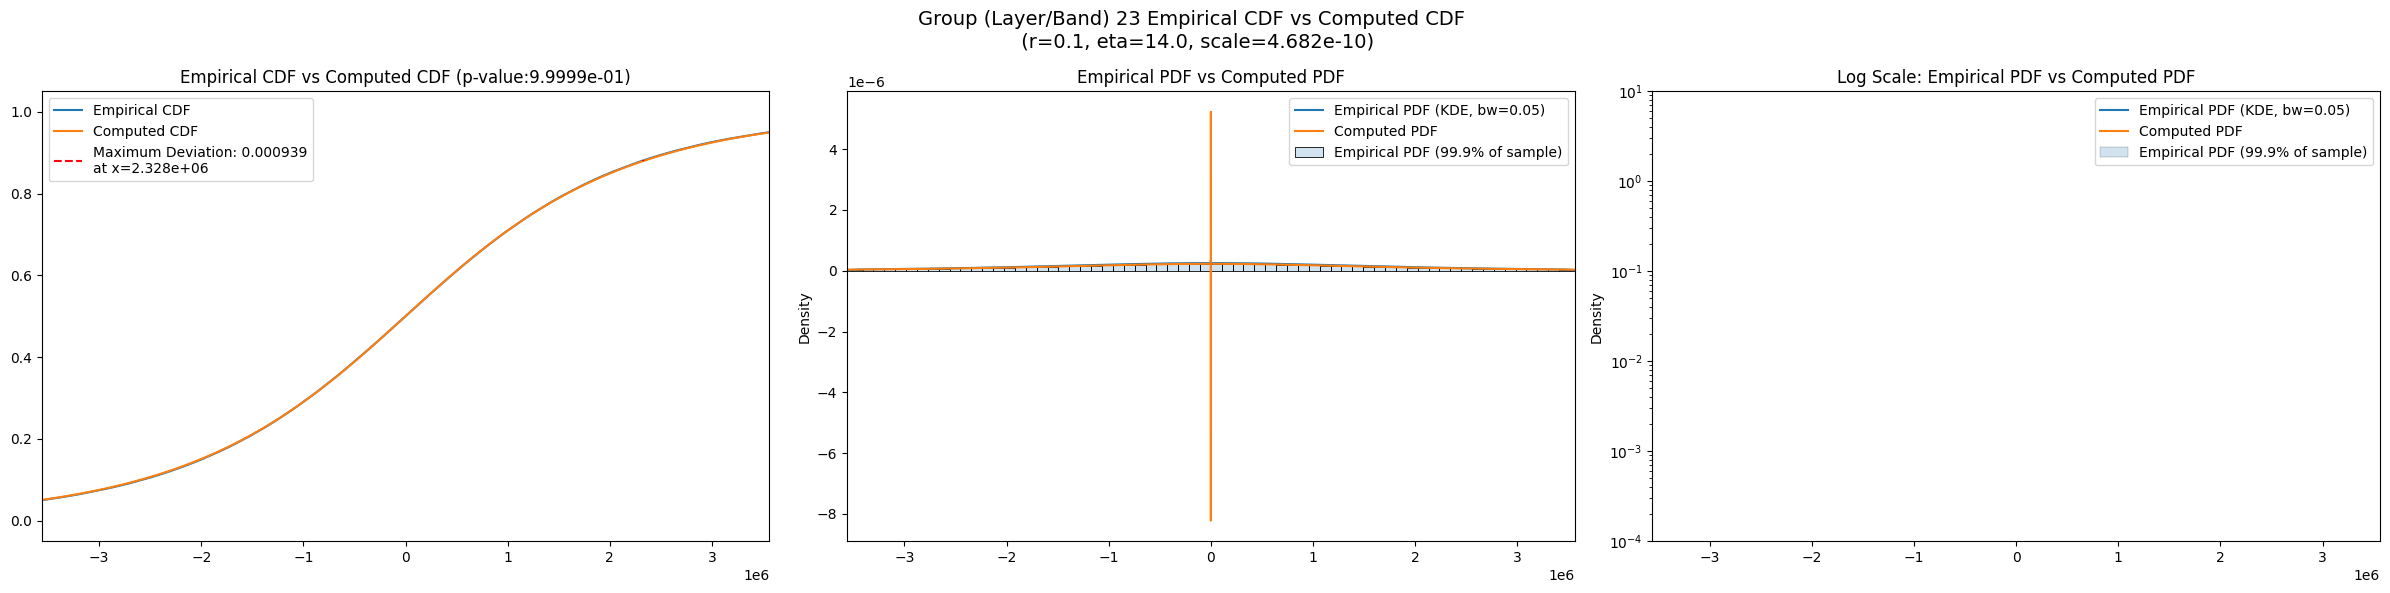

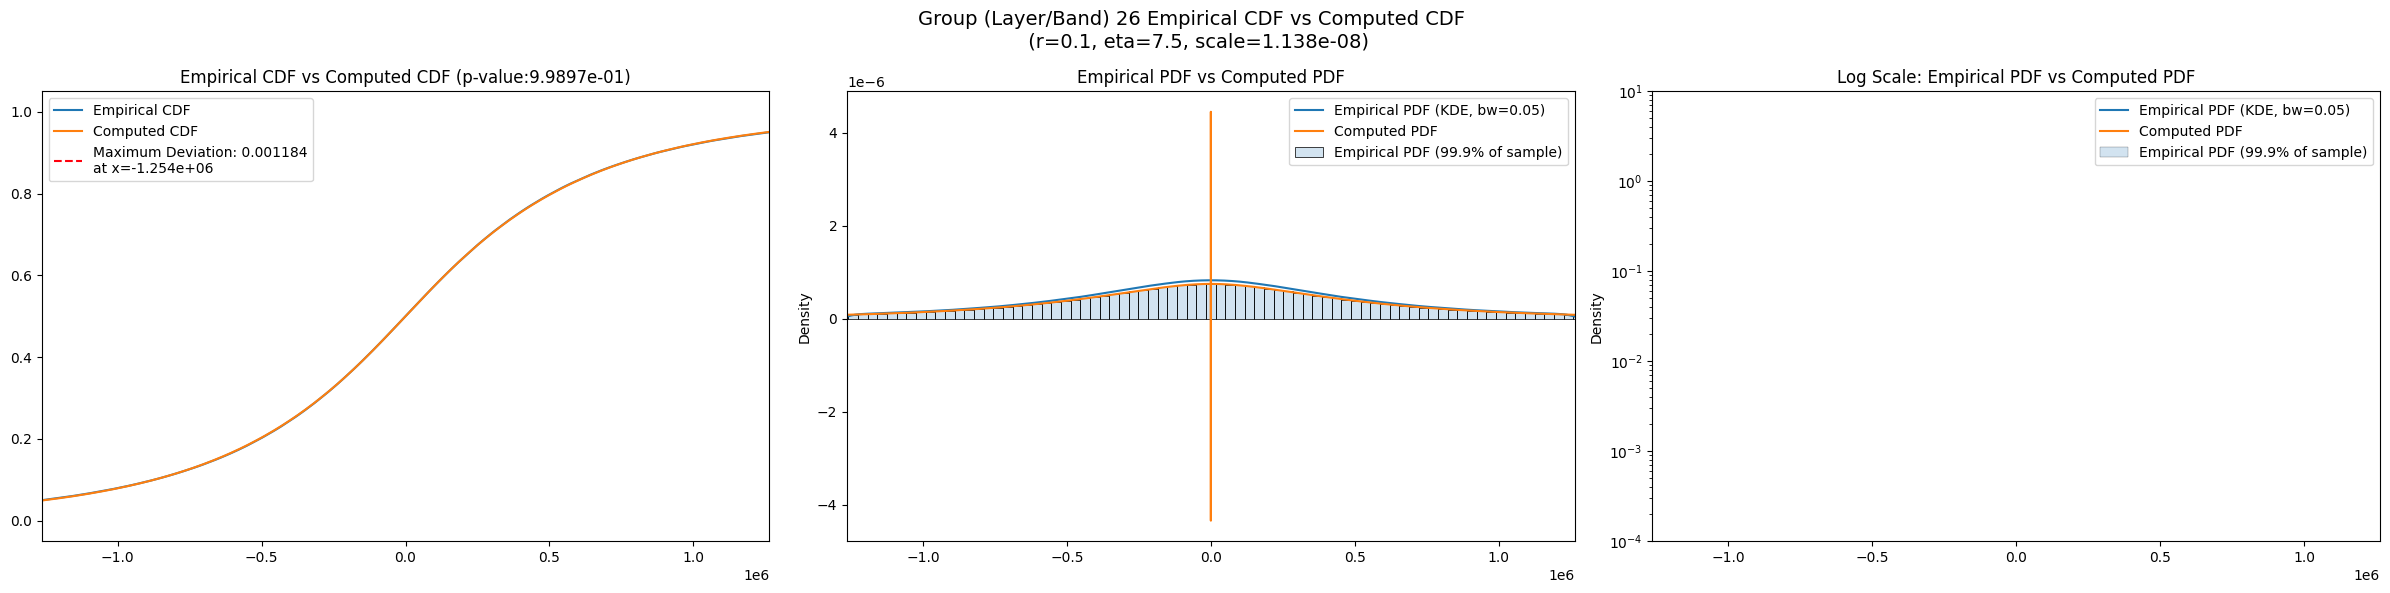

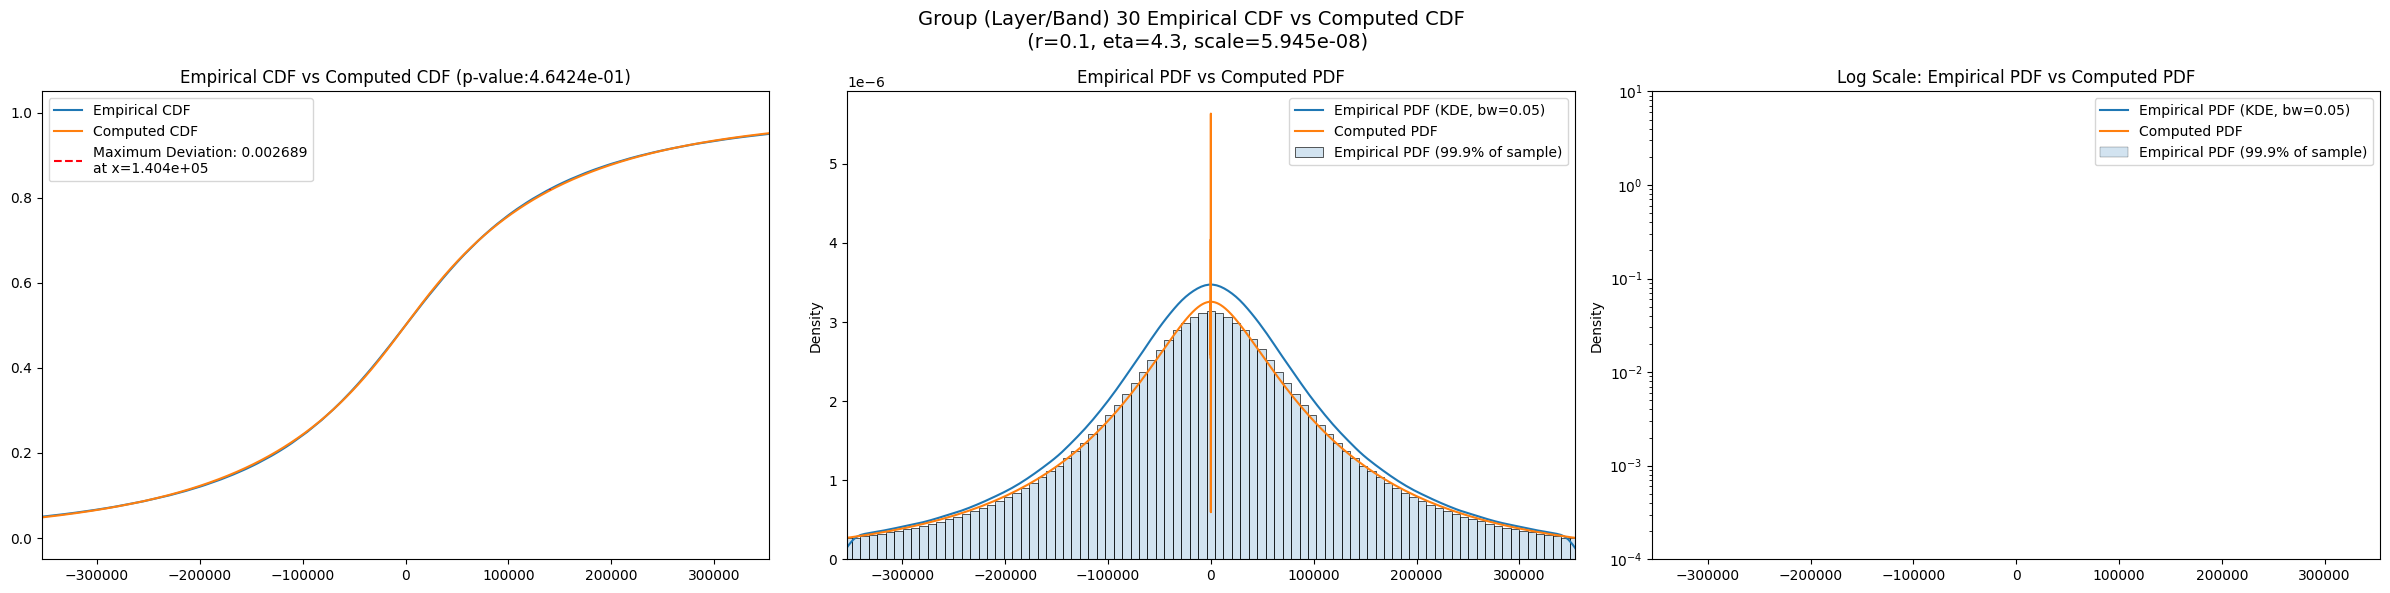

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,1.780652e+14,1.566946e+14,2.012036e+14,1.385106,0.440610,2.452241,720.0,0.012857,0.2,13.0,...,1000000.0,0.405595,1.575460e-107,1000000.0,0.368299,4.234180e-88,1000000.0,0.344476,8.310220e-77,9.999993e-01
5,3.248256e+14,2.793989e+14,3.749020e+14,30.696776,22.475871,38.184085,7200.0,0.007942,0.1,11.0,...,1000000.0,0.403665,0.000000e+00,1000000.0,0.365511,0.000000e+00,1000000.0,0.341788,0.000000e+00,7.509946e-01
8,5.841084e+13,4.986194e+13,6.893457e+13,38.618811,16.443359,62.146887,13680.0,0.004571,0.2,14.0,...,1000000.0,0.341173,0.000000e+00,1000000.0,0.295132,0.000000e+00,1000000.0,0.271092,0.000000e+00,9.361516e-01
11,7.163443e+12,6.796063e+12,7.560022e+12,2.201127,1.144515,3.771432,28080.0,0.001673,0.2,20.0,...,1000000.0,0.202202,0.000000e+00,1000000.0,0.159916,0.000000e+00,1000000.0,0.134496,0.000000e+00,1.000000e+00
14,8.842492e+13,7.518536e+13,1.036462e+14,37.136614,26.742732,55.959008,56160.0,0.014268,0.1,0.8,...,1000000.0,0.181403,0.000000e+00,1000000.0,0.134691,0.000000e+00,1000000.0,0.110389,0.000000e+00,6.361825e-08
17,4.552992e+14,4.295654e+14,4.832774e+14,3.260257,2.260875,6.270571,450720.0,0.007544,0.1,7.8,...,1000000.0,0.419404,0.000000e+00,1000000.0,0.386094,0.000000e+00,1000000.0,0.363155,0.000000e+00,1.040332e-22
20,3.092927e+13,2.903165e+13,3.301717e+13,4.174451,2.502771,8.405625,901440.0,0.000736,0.1,12.0,...,1000000.0,0.300238,0.000000e+00,1000000.0,0.253498,0.000000e+00,1000000.0,0.229325,0.000000e+00,7.134815e-01
23,5.115722e+12,4.809646e+12,5.481501e+12,4.293492,2.139704,14.028609,7211520.0,0.000939,0.1,14.0,...,1000000.0,0.144270,0.000000e+00,1000000.0,0.106810,0.000000e+00,1000000.0,0.080067,0.000000e+00,6.012592e-06
26,6.767911e+11,6.216029e+11,7.682348e+11,14.193115,3.902409,66.812514,3605760.0,0.001184,0.1,7.5,...,648274.0,0.024960,0.000000e+00,567644.0,0.007234,2.662080e-164,456247.0,0.009057,2.330930e-257,8.078176e-05


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.012857,0.050376,0.009986,0.405595,0.368299,0.344476
5,0.007942,0.015982,0.007942,0.403665,0.365511,0.341788
8,0.004571,0.011599,0.004571,0.341173,0.295132,0.271092
11,0.001673,0.008099,0.001463,0.202202,0.159916,0.134496
14,0.014268,0.005728,0.012394,0.181403,0.134691,0.110389
17,0.007544,0.002023,0.007544,0.419404,0.386094,0.363155
20,0.000736,0.001430,0.000736,0.300238,0.253498,0.229325
23,0.000939,0.000506,0.000939,0.144270,0.106810,0.080067
26,0.001184,0.000715,0.001184,0.024960,0.007234,0.009057


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,1.780652e+14,0.009986,0.16,13.0,8.725070e+01,0.0
5,1.746783e+14,0.007942,0.10,11.0,1.320110e-07,75.0
8,3.910740e+13,0.004571,0.20,14.0,1.232443e+04,75.0
11,6.804531e+12,0.001463,0.21,20.0,1.670505e+03,50.0
14,4.349914e+13,0.012394,0.09,1.1,4.482071e-04,550.0
17,4.552992e+14,0.007544,0.10,7.8,5.890290e-06,0.0
20,3.009891e+13,0.000736,0.10,12.0,1.080761e-08,25.0
23,4.981120e+12,0.000939,0.10,14.0,4.681925e-10,25.0
26,6.436384e+11,0.001184,0.10,7.5,1.138496e-08,25.0
